In [50]:
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt


def graf(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(28)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [75]:
import pathlib

data_dir = pathlib.Path('train')
adidas = list(data_dir.glob('adidas/*'))
converse = list(data_dir.glob('converse/*'))
nike = list(data_dir.glob('nike/*'))

In [76]:
#osnovni parametri za slikite
batch_size = 32
img_height = 250
img_width = 250

In [77]:
#definicja na treniracko mnozestvo
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 697 files belonging to 3 classes.
Using 558 files for training.


In [78]:
#definicija na validacisko mnozestvo
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [79]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [80]:
num_classes = len(class_names)

#definicja na modelot
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),  #reskaliracki sloj
    layers.Conv2D(16, 3, padding='same', activation='relu'),  #2d konvoluciski sloj
    layers.MaxPooling2D(),  #maksimiziracki sloj
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),  #izmaznuvacki sloj
    layers.Dense(128, activation='relu'),  #sloj na obicna nevronska mreza (povekesloen perceptron)
    layers.Dense(num_classes)
])

Found 697 files belonging to 3 classes.
Using 139 files for validation.


In [32]:
#definicija na optimizator za modelot i zadavanje na funkcija na gubitok
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
#prvicno treniranje na modelot
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10


C:\Users\darso\miniconda3\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - 42s 2s/step - loss: 0.7771 - accuracy: 0.7204 - val_loss: 0.8860 - val_accuracy: 0.6043
Epoch 2/10
18/18 [==============================] - 38s 2s/step - loss: 0.5138 - accuracy: 0.7957 - val_loss: 0.9281 - val_accuracy: 0.6475
Epoch 3/10
18/18 [==============================] - 36s 2s/step - loss: 0.3646 - accuracy: 0.8746 - val_loss: 0.9336 - val_accuracy: 0.6619
Epoch 4/10
18/18 [==============================] - 36s 2s/step - loss: 0.2227 - accuracy: 0.9229 - val_loss: 1.2467 - val_accuracy: 0.6763
Epoch 5/10
18/18 [==============================] - 36s 2s/step - loss: 0.1665 - accuracy: 0.9444 - val_loss: 1.3927 - val_accuracy: 0.6619
Epoch 6/10
18/18 [==============================] - 37s 2s/step - loss: 0.1613 - accuracy: 0.9462 - val_loss: 1.4066 - val_accuracy: 0.6475
Epoch 7/10
18/18 [==============================] - 38s 2s/step - loss: 0.1095 - accuracy: 0.9659 - val_loss: 1.4059 - val_accuracy: 0.7050
Epoch 8/10
18/18 [=============

In [83]:
#vizuelizacija na podatocite od treniranjeto
graf(history);

In [34]:
#augmentacija na podatocite
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), #nov sloj
        layers.RandomContrast(factor=0.1), #nov sloj
    ] 
)

In [39]:
#nova definicija na modelot po augmentacija
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') 
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [41]:
#povtorno treniranje na modelot po augmentacija
epochs = 11
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/11
18/18 [==============================] - 22s 1s/step - loss: 1.4342 - accuracy: 0.3387 - val_loss: 1.0952 - val_accuracy: 0.3094
Epoch 2/11
18/18 [==============================] - 20s 1s/step - loss: 1.0882 - accuracy: 0.3710 - val_loss: 1.0763 - val_accuracy: 0.4245
Epoch 3/11
18/18 [==============================] - 20s 1s/step - loss: 1.0667 - accuracy: 0.4409 - val_loss: 1.0578 - val_accuracy: 0.4964
Epoch 4/11
18/18 [==============================] - 21s 1s/step - loss: 1.0425 - accuracy: 0.4803 - val_loss: 1.0157 - val_accuracy: 0.4532
Epoch 5/11
18/18 [==============================] - 22s 1s/step - loss: 1.0285 - accuracy: 0.4821 - val_loss: 1.0038 - val_accuracy: 0.4820
Epoch 6/11
18/18 [==============================] - 19s 1s/step - loss: 1.0304 - accuracy: 0.5090 - val_loss: 1.0104 - val_accuracy: 0.4964
Epoch 7/11
18/18 [==============================] - 20s 1s/step - loss: 0.9789 - accuracy: 0.5323 - val_loss: 1.0000 - val_accuracy: 0.4964
Epoch 8/11
18/18 [==

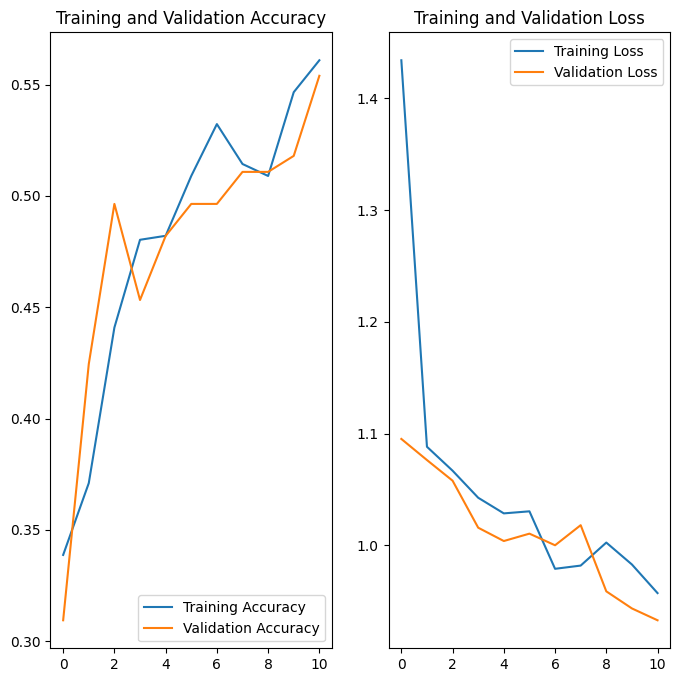

In [42]:
#povtorna vizuelizacija na podatocite
graf(history)

In [101]:
#zacuvuvanje na modelot
model.save('final_model/model')


GridSearchCV(cv=2,
             estimator=KerasClassifier(model=<keras.src.engine.sequential.Sequential object at 0x000001AE72CB2CD0>),
             param_grid={'batch_size': [64], 'epochs': [1, 2],
                         'optimizer': ['adam']})

In [17]:
import numpy as np

X_train = np.concatenate([x for x, _ in train_ds], axis=0)
y_train = np.concatenate([y for _, y in train_ds], axis=0)

X_val = np.concatenate([x for x, _ in val_ds], axis=0)
y_val = np.concatenate([y for _, y in val_ds], axis=0)

In [29]:
def create_model():
    model = keras.Sequential([
        data_augmentation,
        layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [30]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

cv_model = KerasClassifier(build_fn=create_model, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

param_grid = {'optimizer': ['adam', 'rmsprop'],
              'epochs': [10, 15, 50, 100],
              'batch_size': [16, 32, 64]}

grid = GridSearchCV(estimator=cv_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 30s 1s/step - loss: 1.6332 - accuracy: 0.3184
Epoch 2/10
28/28 [==============================] - 28s 1s/step - loss: 1.0998 - accuracy: 0.3700
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 1.0954 - accuracy: 0.3543
Epoch 4/10
28/28 [==============================] - 29s 1s/step - loss: 1.0688 - accuracy: 0.4574
Epoch 5/10
28/28 [==============================] - 28s 1s/step - loss: 0.9440 - accuracy: 0.5426
Epoch 6/10
28/28 [==============================] - 28s 1s/step - loss: 0.7545 - accuracy: 0.6278
Epoch 7/10
28/28 [==============================] - 28s 1s/step - loss: 0.5928 - accuracy: 0.7242
Epoch 8/10
28/28 [==============================] - 28s 1s/step - loss: 0.3804 - accuracy: 0.8430
Epoch 9/10
28/28 [==============================] - 28s 1s/step - loss: 0.3323 - accuracy: 0.8677
Epoch 10/10
7/7 [==============================] - 1s 176ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 31s 1s/step - loss: 1.6566 - accuracy: 0.3251
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 1.1019 - accuracy: 0.3700
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 1.0952 - accuracy: 0.3767
Epoch 4/10
28/28 [==============================] - 30s 1s/step - loss: 1.0995 - accuracy: 0.4260
Epoch 5/10
28/28 [==============================] - 28s 1s/step - loss: 1.0003 - accuracy: 0.4978
Epoch 6/10
28/28 [==============================] - 27s 982ms/step - loss: 0.8283 - accuracy: 0.5897
Epoch 7/10
28/28 [==============================] - 28s 1s/step - loss: 0.6291 - accuracy: 0.7242
Epoch 8/10
28/28 [==============================] - 28s 1s/step - loss: 0.4507 - accuracy: 0.7937
Epoch 9/10
28/28 [==============================] - 28s 1s/step - loss: 0.3384 - accuracy: 0.8655
Epoch 10/10
7/7 [==============================] - 1s 187ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 30s 1s/step - loss: 1.4850 - accuracy: 0.3610
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 1.0931 - accuracy: 0.3789
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 1.0750 - accuracy: 0.4596
Epoch 4/10
28/28 [==============================] - 29s 1s/step - loss: 1.0394 - accuracy: 0.4552
Epoch 5/10
28/28 [==============================] - 30s 1s/step - loss: 0.9681 - accuracy: 0.5471
Epoch 6/10
28/28 [==============================] - 29s 1s/step - loss: 0.7530 - accuracy: 0.6749
Epoch 7/10
28/28 [==============================] - 28s 1s/step - loss: 0.5873 - accuracy: 0.7623
Epoch 8/10
28/28 [==============================] - 27s 981ms/step - loss: 0.4033 - accuracy: 0.8430
Epoch 9/10
28/28 [==============================] - 28s 1s/step - loss: 0.3117 - accuracy: 0.9013
Epoch 10/10
7/7 [==============================] - 1s 174ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 29s 1s/step - loss: 1.4810 - accuracy: 0.2841
Epoch 2/10
28/28 [==============================] - 28s 1s/step - loss: 1.0993 - accuracy: 0.3512
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 1.0973 - accuracy: 0.3893
Epoch 4/10
28/28 [==============================] - 28s 1s/step - loss: 1.0747 - accuracy: 0.4251
Epoch 5/10
28/28 [==============================] - 29s 1s/step - loss: 0.9959 - accuracy: 0.4855
Epoch 6/10
28/28 [==============================] - 28s 1s/step - loss: 0.8520 - accuracy: 0.6063
Epoch 7/10
28/28 [==============================] - 28s 1s/step - loss: 0.6798 - accuracy: 0.6823
Epoch 8/10
28/28 [==============================] - 29s 1s/step - loss: 0.5048 - accuracy: 0.7830
Epoch 9/10
28/28 [==============================] - 28s 1s/step - loss: 0.3971 - accuracy: 0.8479
Epoch 10/10
7/7 [==============================] - 1s 166ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 30s 1s/step - loss: 1.7061 - accuracy: 0.3289
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 1.1179 - accuracy: 0.3736
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 1.0825 - accuracy: 0.4273
Epoch 4/10
28/28 [==============================] - 29s 1s/step - loss: 1.0015 - accuracy: 0.5168
Epoch 5/10
28/28 [==============================] - 29s 1s/step - loss: 0.8880 - accuracy: 0.6040
Epoch 6/10
28/28 [==============================] - 29s 1s/step - loss: 0.7636 - accuracy: 0.6689
Epoch 7/10
28/28 [==============================] - 28s 1s/step - loss: 0.5809 - accuracy: 0.7539
Epoch 8/10
28/28 [==============================] - 28s 1s/step - loss: 0.4255 - accuracy: 0.8166
Epoch 9/10
28/28 [==============================] - 28s 1s/step - loss: 0.3297 - accuracy: 0.8792
Epoch 10/10
7/7 [==============================] - 1s 164ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 32s 1s/step - loss: 2.0272 - accuracy: 0.3318
Epoch 2/10
28/28 [==============================] - 27s 976ms/step - loss: 1.1272 - accuracy: 0.3363
Epoch 3/10
28/28 [==============================] - 27s 962ms/step - loss: 1.0939 - accuracy: 0.4058
Epoch 4/10
28/28 [==============================] - 27s 975ms/step - loss: 1.0922 - accuracy: 0.4058
Epoch 5/10
28/28 [==============================] - 27s 965ms/step - loss: 1.0704 - accuracy: 0.4439
Epoch 6/10
28/28 [==============================] - 28s 999ms/step - loss: 1.0178 - accuracy: 0.4865
Epoch 7/10
28/28 [==============================] - 27s 977ms/step - loss: 0.9060 - accuracy: 0.5650
Epoch 8/10
28/28 [==============================] - 27s 959ms/step - loss: 0.7460 - accuracy: 0.6682
Epoch 9/10
28/28 [==============================] - 27s 965ms/step - loss: 0.6111 - accuracy: 0.7511
Epoch 10/10
7/7 [==============================] - 1s 177ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 28s 981ms/step - loss: 1.6265 - accuracy: 0.3453
Epoch 2/10
28/28 [==============================] - 27s 965ms/step - loss: 1.1202 - accuracy: 0.3789
Epoch 3/10
28/28 [==============================] - 27s 966ms/step - loss: 1.1036 - accuracy: 0.4081
Epoch 4/10
28/28 [==============================] - 28s 983ms/step - loss: 1.0849 - accuracy: 0.3812
Epoch 5/10
28/28 [==============================] - 27s 973ms/step - loss: 1.0500 - accuracy: 0.4798
Epoch 6/10
28/28 [==============================] - 27s 961ms/step - loss: 0.9840 - accuracy: 0.5135
Epoch 7/10
28/28 [==============================] - 28s 991ms/step - loss: 0.8755 - accuracy: 0.5762
Epoch 8/10
28/28 [==============================] - 28s 1s/step - loss: 0.7439 - accuracy: 0.6637
Epoch 9/10
28/28 [==============================] - 28s 1s/step - loss: 0.4760 - accuracy: 0.8027
Epoch 10/10
7/7 [==============================] - 1s 172ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 28s 974ms/step - loss: 3.0689 - accuracy: 0.3206
Epoch 2/10
28/28 [==============================] - 27s 955ms/step - loss: 1.1280 - accuracy: 0.3363
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 1.1997 - accuracy: 0.3475
Epoch 4/10
28/28 [==============================] - 27s 961ms/step - loss: 1.1099 - accuracy: 0.3543
Epoch 5/10
28/28 [==============================] - 27s 974ms/step - loss: 1.0913 - accuracy: 0.4238
Epoch 6/10
28/28 [==============================] - 28s 990ms/step - loss: 1.0760 - accuracy: 0.4170
Epoch 7/10
28/28 [==============================] - 29s 1s/step - loss: 1.0234 - accuracy: 0.5067
Epoch 8/10
28/28 [==============================] - 28s 1s/step - loss: 0.9534 - accuracy: 0.5987
Epoch 9/10
28/28 [==============================] - 28s 983ms/step - loss: 0.6967 - accuracy: 0.6996
Epoch 10/10
7/7 [==============================] - 1s 172ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 28s 976ms/step - loss: 2.3755 - accuracy: 0.3266
Epoch 2/10
28/28 [==============================] - 27s 975ms/step - loss: 1.1302 - accuracy: 0.3736
Epoch 3/10
28/28 [==============================] - 28s 986ms/step - loss: 1.1084 - accuracy: 0.3356
Epoch 4/10
28/28 [==============================] - 28s 1s/step - loss: 1.1158 - accuracy: 0.3669
Epoch 5/10
28/28 [==============================] - 29s 1s/step - loss: 1.0598 - accuracy: 0.4676
Epoch 6/10
28/28 [==============================] - 29s 1s/step - loss: 0.9420 - accuracy: 0.5526
Epoch 7/10
28/28 [==============================] - 29s 1s/step - loss: 0.8127 - accuracy: 0.6689
Epoch 8/10
28/28 [==============================] - 29s 1s/step - loss: 0.6838 - accuracy: 0.7204
Epoch 9/10
28/28 [==============================] - 27s 980ms/step - loss: 0.4838 - accuracy: 0.8345
Epoch 10/10
7/7 [==============================] - 1s 175ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
28/28 [==============================] - 28s 981ms/step - loss: 2.2574 - accuracy: 0.3289
Epoch 2/10
28/28 [==============================] - 28s 993ms/step - loss: 1.1170 - accuracy: 0.3736
Epoch 3/10
28/28 [==============================] - 28s 982ms/step - loss: 1.1131 - accuracy: 0.3848
Epoch 4/10
28/28 [==============================] - 28s 988ms/step - loss: 1.1171 - accuracy: 0.3669
Epoch 5/10
28/28 [==============================] - 28s 1s/step - loss: 1.0414 - accuracy: 0.4497
Epoch 6/10
28/28 [==============================] - 28s 995ms/step - loss: 0.9925 - accuracy: 0.4989
Epoch 7/10
28/28 [==============================] - 28s 982ms/step - loss: 0.8875 - accuracy: 0.5973
Epoch 8/10
28/28 [==============================] - 28s 986ms/step - loss: 0.6964 - accuracy: 0.7025
Epoch 9/10
28/28 [==============================] - 28s 991ms/step - loss: 0.5745 - accuracy: 0.7897
Epoch 10/10
7/7 [==============================] - 1s 162ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 29s 1s/step - loss: 1.4961 - accuracy: 0.3498
Epoch 2/15
28/28 [==============================] - 28s 1000ms/step - loss: 1.0995 - accuracy: 0.3318
Epoch 3/15
28/28 [==============================] - 28s 1s/step - loss: 1.0961 - accuracy: 0.3901
Epoch 4/15
28/28 [==============================] - 28s 1s/step - loss: 1.0923 - accuracy: 0.3789
Epoch 5/15
28/28 [==============================] - 28s 1s/step - loss: 1.0415 - accuracy: 0.4641
Epoch 6/15
28/28 [==============================] - 28s 996ms/step - loss: 0.9036 - accuracy: 0.5448
Epoch 7/15
28/28 [==============================] - 28s 1s/step - loss: 0.6919 - accuracy: 0.7265
Epoch 8/15
28/28 [==============================] - 28s 997ms/step - loss: 0.5691 - accuracy: 0.7556
Epoch 9/15
28/28 [==============================] - 29s 1s/step - loss: 0.4163 - accuracy: 0.8296
Epoch 10/15
28/28 [==============================] - 29s 1s/step - loss: 0.3570 - accuracy: 0.8632
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 29s 1s/step - loss: 1.6854 - accuracy: 0.3206
Epoch 2/15
28/28 [==============================] - 28s 1s/step - loss: 1.1039 - accuracy: 0.3587
Epoch 3/15
28/28 [==============================] - 28s 995ms/step - loss: 1.0872 - accuracy: 0.3722
Epoch 4/15
28/28 [==============================] - 28s 1s/step - loss: 0.9998 - accuracy: 0.5067
Epoch 5/15
28/28 [==============================] - 28s 996ms/step - loss: 0.8784 - accuracy: 0.5852
Epoch 6/15
28/28 [==============================] - 28s 1s/step - loss: 0.7954 - accuracy: 0.6256
Epoch 7/15
28/28 [==============================] - 29s 1s/step - loss: 0.5936 - accuracy: 0.7422
Epoch 8/15
28/28 [==============================] - 29s 1s/step - loss: 0.4146 - accuracy: 0.8139
Epoch 9/15
28/28 [==============================] - 29s 1s/step - loss: 0.3600 - accuracy: 0.8744
Epoch 10/15
28/28 [==============================] - 28s 1s/step - loss: 0.3192 - accuracy: 0.8991
Epoch 11/15
2

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 29s 998ms/step - loss: 1.4445 - accuracy: 0.3117
Epoch 2/15
28/28 [==============================] - 28s 996ms/step - loss: 1.1093 - accuracy: 0.3632
Epoch 3/15
28/28 [==============================] - 28s 1s/step - loss: 1.0948 - accuracy: 0.3700
Epoch 4/15
28/28 [==============================] - 28s 1s/step - loss: 1.0613 - accuracy: 0.4910
Epoch 5/15
28/28 [==============================] - 28s 999ms/step - loss: 0.9431 - accuracy: 0.5807
Epoch 6/15
28/28 [==============================] - 30s 1s/step - loss: 0.7375 - accuracy: 0.6704
Epoch 7/15
28/28 [==============================] - 28s 1s/step - loss: 0.5371 - accuracy: 0.7489
Epoch 8/15
28/28 [==============================] - 28s 994ms/step - loss: 0.4520 - accuracy: 0.8184
Epoch 9/15
28/28 [==============================] - 28s 1s/step - loss: 0.3387 - accuracy: 0.8520
Epoch 10/15
28/28 [==============================] - 28s 1s/step - loss: 0.2475 - accuracy: 0.8879
Epoch 1

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 29s 998ms/step - loss: 1.4558 - accuracy: 0.3468
Epoch 2/15
28/28 [==============================] - 28s 1s/step - loss: 1.0989 - accuracy: 0.3714
Epoch 3/15
28/28 [==============================] - 28s 990ms/step - loss: 1.0801 - accuracy: 0.3982
Epoch 4/15
28/28 [==============================] - 29s 1s/step - loss: 1.0328 - accuracy: 0.5123
Epoch 5/15
28/28 [==============================] - 28s 1s/step - loss: 0.8689 - accuracy: 0.6063
Epoch 6/15
28/28 [==============================] - 31s 1s/step - loss: 0.7143 - accuracy: 0.6846
Epoch 7/15
28/28 [==============================] - 30s 1s/step - loss: 0.5627 - accuracy: 0.7606
Epoch 8/15
28/28 [==============================] - 29s 1s/step - loss: 0.3954 - accuracy: 0.8456
Epoch 9/15
28/28 [==============================] - 28s 1s/step - loss: 0.2410 - accuracy: 0.9083
Epoch 10/15
28/28 [==============================] - 28s 998ms/step - loss: 0.2551 - accuracy: 0.9374
Epoch 11/1

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 30s 1s/step - loss: 1.5724 - accuracy: 0.3714
Epoch 2/15
28/28 [==============================] - 28s 1s/step - loss: 1.0957 - accuracy: 0.3647
Epoch 3/15
28/28 [==============================] - 30s 1s/step - loss: 1.0802 - accuracy: 0.4541
Epoch 4/15
28/28 [==============================] - 28s 1s/step - loss: 0.9768 - accuracy: 0.5280
Epoch 5/15
28/28 [==============================] - 28s 1000ms/step - loss: 0.8130 - accuracy: 0.6242
Epoch 6/15
28/28 [==============================] - 28s 1s/step - loss: 0.6174 - accuracy: 0.7383
Epoch 7/15
28/28 [==============================] - 28s 994ms/step - loss: 0.4647 - accuracy: 0.7987
Epoch 8/15
28/28 [==============================] - 28s 1s/step - loss: 0.3508 - accuracy: 0.8613
Epoch 9/15
28/28 [==============================] - 28s 1s/step - loss: 0.3095 - accuracy: 0.8971
Epoch 10/15
28/28 [==============================] - 28s 1s/step - loss: 0.2317 - accuracy: 0.9306
Epoch 11/15


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 27s 935ms/step - loss: 2.5801 - accuracy: 0.3072
Epoch 2/15
28/28 [==============================] - 26s 943ms/step - loss: 1.1253 - accuracy: 0.3363
Epoch 3/15
28/28 [==============================] - 27s 959ms/step - loss: 1.1077 - accuracy: 0.3632
Epoch 4/15
28/28 [==============================] - 28s 985ms/step - loss: 1.1538 - accuracy: 0.4103
Epoch 5/15
28/28 [==============================] - 29s 1s/step - loss: 1.0944 - accuracy: 0.4036
Epoch 6/15
28/28 [==============================] - 27s 962ms/step - loss: 1.0914 - accuracy: 0.4327
Epoch 7/15
28/28 [==============================] - 26s 943ms/step - loss: 0.9925 - accuracy: 0.5022
Epoch 8/15
28/28 [==============================] - 26s 947ms/step - loss: 0.9047 - accuracy: 0.5650
Epoch 9/15
28/28 [==============================] - 27s 955ms/step - loss: 0.8850 - accuracy: 0.6435
Epoch 10/15
28/28 [==============================] - 27s 953ms/step - loss: 0.6378 - accuracy:

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 28s 969ms/step - loss: 2.6698 - accuracy: 0.3229
Epoch 2/15
28/28 [==============================] - 27s 970ms/step - loss: 1.1278 - accuracy: 0.3565
Epoch 3/15
28/28 [==============================] - 27s 953ms/step - loss: 1.1321 - accuracy: 0.3834
Epoch 4/15
28/28 [==============================] - 27s 962ms/step - loss: 1.0829 - accuracy: 0.3857
Epoch 5/15
28/28 [==============================] - 27s 970ms/step - loss: 1.0734 - accuracy: 0.3744
Epoch 6/15
28/28 [==============================] - 27s 952ms/step - loss: 1.0179 - accuracy: 0.4821
Epoch 7/15
28/28 [==============================] - 27s 962ms/step - loss: 0.8900 - accuracy: 0.6099
Epoch 8/15
28/28 [==============================] - 27s 972ms/step - loss: 0.7282 - accuracy: 0.6973
Epoch 9/15
28/28 [==============================] - 27s 961ms/step - loss: 0.5399 - accuracy: 0.7960
Epoch 10/15
28/28 [==============================] - 27s 960ms/step - loss: 0.4682 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 28s 959ms/step - loss: 1.6340 - accuracy: 0.3475
Epoch 2/15
28/28 [==============================] - 26s 946ms/step - loss: 1.1072 - accuracy: 0.3834
Epoch 3/15
28/28 [==============================] - 27s 983ms/step - loss: 1.1171 - accuracy: 0.3543
Epoch 4/15
28/28 [==============================] - 28s 985ms/step - loss: 1.0819 - accuracy: 0.3744
Epoch 5/15
28/28 [==============================] - 27s 980ms/step - loss: 1.0845 - accuracy: 0.4081
Epoch 6/15
28/28 [==============================] - 28s 991ms/step - loss: 1.0722 - accuracy: 0.4664
Epoch 7/15
28/28 [==============================] - 26s 941ms/step - loss: 1.0080 - accuracy: 0.5359
Epoch 8/15
28/28 [==============================] - 27s 957ms/step - loss: 0.8705 - accuracy: 0.6166
Epoch 9/15
28/28 [==============================] - 28s 1s/step - loss: 0.7000 - accuracy: 0.6816
Epoch 10/15
28/28 [==============================] - 27s 959ms/step - loss: 0.5285 - accuracy:

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 28s 969ms/step - loss: 3.1761 - accuracy: 0.3289
Epoch 2/15
28/28 [==============================] - 27s 963ms/step - loss: 1.1253 - accuracy: 0.3221
Epoch 3/15
28/28 [==============================] - 27s 971ms/step - loss: 1.1111 - accuracy: 0.3803
Epoch 4/15
28/28 [==============================] - 27s 964ms/step - loss: 1.1879 - accuracy: 0.4340
Epoch 5/15
28/28 [==============================] - 28s 992ms/step - loss: 1.0770 - accuracy: 0.4653
Epoch 6/15
28/28 [==============================] - 27s 960ms/step - loss: 0.9864 - accuracy: 0.5593
Epoch 7/15
28/28 [==============================] - 27s 962ms/step - loss: 0.8352 - accuracy: 0.6443
Epoch 8/15
28/28 [==============================] - 27s 973ms/step - loss: 0.5952 - accuracy: 0.7450
Epoch 9/15
28/28 [==============================] - 28s 983ms/step - loss: 0.3950 - accuracy: 0.8412
Epoch 10/15
28/28 [==============================] - 27s 960ms/step - loss: 0.3796 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
28/28 [==============================] - 28s 981ms/step - loss: 1.7583 - accuracy: 0.3378
Epoch 2/15
28/28 [==============================] - 27s 960ms/step - loss: 1.1090 - accuracy: 0.3333
Epoch 3/15
28/28 [==============================] - 27s 959ms/step - loss: 1.1219 - accuracy: 0.3333
Epoch 4/15
28/28 [==============================] - 27s 955ms/step - loss: 1.1509 - accuracy: 0.3937
Epoch 5/15
28/28 [==============================] - 27s 952ms/step - loss: 1.0629 - accuracy: 0.4273
Epoch 6/15
28/28 [==============================] - 27s 966ms/step - loss: 0.9499 - accuracy: 0.5414
Epoch 7/15
28/28 [==============================] - 28s 993ms/step - loss: 0.8057 - accuracy: 0.6779
Epoch 8/15
28/28 [==============================] - 27s 965ms/step - loss: 0.7018 - accuracy: 0.6980
Epoch 9/15
28/28 [==============================] - 27s 970ms/step - loss: 0.4978 - accuracy: 0.8143
Epoch 10/15
28/28 [==============================] - 27s 974ms/step - loss: 0.3788 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 29s 995ms/step - loss: 2.1946 - accuracy: 0.3363
Epoch 2/50
28/28 [==============================] - 28s 997ms/step - loss: 1.0923 - accuracy: 0.3655
Epoch 3/50
28/28 [==============================] - 28s 997ms/step - loss: 1.1080 - accuracy: 0.3655
Epoch 4/50
28/28 [==============================] - 28s 991ms/step - loss: 1.0711 - accuracy: 0.4484
Epoch 5/50
28/28 [==============================] - 28s 994ms/step - loss: 1.0019 - accuracy: 0.5448
Epoch 6/50
28/28 [==============================] - 28s 992ms/step - loss: 0.9057 - accuracy: 0.5583
Epoch 7/50
28/28 [==============================] - 28s 994ms/step - loss: 0.7349 - accuracy: 0.6704
Epoch 8/50
28/28 [==============================] - 28s 997ms/step - loss: 0.5812 - accuracy: 0.7713
Epoch 9/50
28/28 [==============================] - 28s 992ms/step - loss: 0.4697 - accuracy: 0.8049
Epoch 10/50
28/28 [==============================] - 28s 999ms/step - loss: 0.3817 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 29s 1s/step - loss: 1.4442 - accuracy: 0.3072
Epoch 2/50
28/28 [==============================] - 28s 1s/step - loss: 1.0963 - accuracy: 0.3386
Epoch 3/50
28/28 [==============================] - 28s 1s/step - loss: 1.0952 - accuracy: 0.3901
Epoch 4/50
28/28 [==============================] - 28s 996ms/step - loss: 1.0646 - accuracy: 0.4484
Epoch 5/50
28/28 [==============================] - 28s 1s/step - loss: 1.0224 - accuracy: 0.4888
Epoch 6/50
28/28 [==============================] - 28s 1s/step - loss: 0.8474 - accuracy: 0.5717
Epoch 7/50
28/28 [==============================] - 28s 1s/step - loss: 0.6657 - accuracy: 0.7175
Epoch 8/50
28/28 [==============================] - 29s 1s/step - loss: 0.4849 - accuracy: 0.8117
Epoch 9/50
28/28 [==============================] - 28s 1s/step - loss: 0.3481 - accuracy: 0.8543
Epoch 10/50
28/28 [==============================] - 29s 1s/step - loss: 0.2513 - accuracy: 0.9081
Epoch 11/50
28/2

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 29s 1s/step - loss: 1.4146 - accuracy: 0.3206
Epoch 2/50
28/28 [==============================] - 28s 989ms/step - loss: 1.0959 - accuracy: 0.3834
Epoch 3/50
28/28 [==============================] - 28s 992ms/step - loss: 1.0918 - accuracy: 0.3767
Epoch 4/50
28/28 [==============================] - 28s 990ms/step - loss: 1.0382 - accuracy: 0.4395
Epoch 5/50
28/28 [==============================] - 28s 983ms/step - loss: 0.9501 - accuracy: 0.5762
Epoch 6/50
28/28 [==============================] - 28s 992ms/step - loss: 0.7936 - accuracy: 0.6637
Epoch 7/50
28/28 [==============================] - 28s 991ms/step - loss: 0.5625 - accuracy: 0.7623
Epoch 8/50
28/28 [==============================] - 29s 1s/step - loss: 0.3841 - accuracy: 0.8274
Epoch 9/50
28/28 [==============================] - 28s 995ms/step - loss: 0.3129 - accuracy: 0.8924
Epoch 10/50
28/28 [==============================] - 28s 1s/step - loss: 0.2389 - accuracy: 0.921

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 28s 954ms/step - loss: 1.8514 - accuracy: 0.3266
Epoch 2/50
28/28 [==============================] - 27s 958ms/step - loss: 1.0987 - accuracy: 0.3870
Epoch 3/50
28/28 [==============================] - 27s 954ms/step - loss: 1.0763 - accuracy: 0.4116
Epoch 4/50
28/28 [==============================] - 27s 960ms/step - loss: 1.0034 - accuracy: 0.4586
Epoch 5/50
28/28 [==============================] - 27s 964ms/step - loss: 0.8619 - accuracy: 0.6040
Epoch 6/50
28/28 [==============================] - 27s 946ms/step - loss: 0.5881 - accuracy: 0.7271
Epoch 7/50
28/28 [==============================] - 27s 952ms/step - loss: 0.4773 - accuracy: 0.7897
Epoch 8/50
28/28 [==============================] - 28s 985ms/step - loss: 0.3761 - accuracy: 0.8546
Epoch 9/50
28/28 [==============================] - 27s 958ms/step - loss: 0.2527 - accuracy: 0.8993
Epoch 10/50
28/28 [==============================] - 27s 963ms/step - loss: 0.1745 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 32s 1s/step - loss: 1.6344 - accuracy: 0.2953
Epoch 2/50
28/28 [==============================] - 28s 988ms/step - loss: 1.1054 - accuracy: 0.3311
Epoch 3/50
28/28 [==============================] - 28s 989ms/step - loss: 1.0937 - accuracy: 0.3691
Epoch 4/50
28/28 [==============================] - 28s 991ms/step - loss: 1.0790 - accuracy: 0.3870
Epoch 5/50
28/28 [==============================] - 28s 983ms/step - loss: 1.0530 - accuracy: 0.4989
Epoch 6/50
28/28 [==============================] - 28s 992ms/step - loss: 0.8823 - accuracy: 0.5526
Epoch 7/50
28/28 [==============================] - 28s 988ms/step - loss: 0.6836 - accuracy: 0.6667
Epoch 8/50
28/28 [==============================] - 28s 983ms/step - loss: 0.5378 - accuracy: 0.7472
Epoch 9/50
28/28 [==============================] - 28s 987ms/step - loss: 0.4511 - accuracy: 0.8054
Epoch 10/50
28/28 [==============================] - 27s 960ms/step - loss: 0.3255 - accuracy:

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 27s 930ms/step - loss: 1.6828 - accuracy: 0.3363
Epoch 2/50
28/28 [==============================] - 26s 914ms/step - loss: 1.1150 - accuracy: 0.3722
Epoch 3/50
28/28 [==============================] - 26s 916ms/step - loss: 1.1012 - accuracy: 0.3363
Epoch 4/50
28/28 [==============================] - 26s 917ms/step - loss: 1.0921 - accuracy: 0.4081
Epoch 5/50
28/28 [==============================] - 26s 921ms/step - loss: 1.0703 - accuracy: 0.4439
Epoch 6/50
28/28 [==============================] - 26s 914ms/step - loss: 0.9975 - accuracy: 0.4910
Epoch 7/50
28/28 [==============================] - 26s 921ms/step - loss: 0.9128 - accuracy: 0.5785
Epoch 8/50
28/28 [==============================] - 25s 910ms/step - loss: 0.7861 - accuracy: 0.6794
Epoch 9/50
28/28 [==============================] - 26s 934ms/step - loss: 0.6112 - accuracy: 0.7668
Epoch 10/50
28/28 [==============================] - 26s 943ms/step - loss: 0.5069 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 28s 983ms/step - loss: 2.2600 - accuracy: 0.3251
Epoch 2/50
28/28 [==============================] - 27s 966ms/step - loss: 1.1351 - accuracy: 0.3251
Epoch 3/50
28/28 [==============================] - 27s 950ms/step - loss: 1.1209 - accuracy: 0.3565
Epoch 4/50
28/28 [==============================] - 27s 966ms/step - loss: 1.1829 - accuracy: 0.4013
Epoch 5/50
28/28 [==============================] - 27s 961ms/step - loss: 1.0911 - accuracy: 0.4148
Epoch 6/50
28/28 [==============================] - 26s 939ms/step - loss: 1.0166 - accuracy: 0.4910
Epoch 7/50
28/28 [==============================] - 26s 938ms/step - loss: 1.0059 - accuracy: 0.5202
Epoch 8/50
28/28 [==============================] - 27s 949ms/step - loss: 0.7593 - accuracy: 0.6726
Epoch 9/50
28/28 [==============================] - 27s 962ms/step - loss: 0.6592 - accuracy: 0.7399
Epoch 10/50
28/28 [==============================] - 27s 968ms/step - loss: 0.5427 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 27s 952ms/step - loss: 2.1536 - accuracy: 0.3520
Epoch 2/50
28/28 [==============================] - 26s 943ms/step - loss: 1.1209 - accuracy: 0.3274
Epoch 3/50
28/28 [==============================] - 26s 935ms/step - loss: 1.1255 - accuracy: 0.3677
Epoch 4/50
28/28 [==============================] - 27s 951ms/step - loss: 1.1036 - accuracy: 0.3812
Epoch 5/50
28/28 [==============================] - 26s 941ms/step - loss: 1.1597 - accuracy: 0.4126
Epoch 6/50
28/28 [==============================] - 26s 942ms/step - loss: 1.0575 - accuracy: 0.4305
Epoch 7/50
28/28 [==============================] - 26s 945ms/step - loss: 1.0083 - accuracy: 0.4955
Epoch 8/50
28/28 [==============================] - 26s 942ms/step - loss: 0.9052 - accuracy: 0.5830
Epoch 9/50
28/28 [==============================] - 26s 945ms/step - loss: 0.7650 - accuracy: 0.6794
Epoch 10/50
28/28 [==============================] - 26s 940ms/step - loss: 0.6172 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 28s 981ms/step - loss: 1.6340 - accuracy: 0.3400
Epoch 2/50
28/28 [==============================] - 28s 982ms/step - loss: 1.1094 - accuracy: 0.3848
Epoch 3/50
28/28 [==============================] - 28s 991ms/step - loss: 1.1436 - accuracy: 0.3512
Epoch 4/50
28/28 [==============================] - 27s 978ms/step - loss: 1.0811 - accuracy: 0.4407
Epoch 5/50
28/28 [==============================] - 27s 977ms/step - loss: 1.0914 - accuracy: 0.4609
Epoch 6/50
28/28 [==============================] - 27s 970ms/step - loss: 0.9856 - accuracy: 0.5213
Epoch 7/50
28/28 [==============================] - 27s 979ms/step - loss: 0.8909 - accuracy: 0.6107
Epoch 8/50
28/28 [==============================] - 27s 970ms/step - loss: 0.7721 - accuracy: 0.7025
Epoch 9/50
28/28 [==============================] - 27s 971ms/step - loss: 0.5536 - accuracy: 0.7919
Epoch 10/50
28/28 [==============================] - 27s 973ms/step - loss: 0.4385 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
28/28 [==============================] - 28s 993ms/step - loss: 1.5920 - accuracy: 0.2975
Epoch 2/50
28/28 [==============================] - 27s 976ms/step - loss: 1.1537 - accuracy: 0.3468
Epoch 3/50
28/28 [==============================] - 28s 984ms/step - loss: 1.1084 - accuracy: 0.3602
Epoch 4/50
28/28 [==============================] - 28s 983ms/step - loss: 1.1149 - accuracy: 0.4027
Epoch 5/50
28/28 [==============================] - 27s 980ms/step - loss: 1.0808 - accuracy: 0.4027
Epoch 6/50
28/28 [==============================] - 27s 981ms/step - loss: 1.0388 - accuracy: 0.4519
Epoch 7/50
28/28 [==============================] - 27s 977ms/step - loss: 1.0126 - accuracy: 0.5190
Epoch 8/50
28/28 [==============================] - 28s 990ms/step - loss: 0.9200 - accuracy: 0.5996
Epoch 9/50
28/28 [==============================] - 27s 978ms/step - loss: 0.8105 - accuracy: 0.6421
Epoch 10/50
28/28 [==============================] - 27s 977ms/step - loss: 0.6237 - accura

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 30s 1s/step - loss: 1.5766 - accuracy: 0.3206
Epoch 2/100
28/28 [==============================] - 29s 1s/step - loss: 1.0976 - accuracy: 0.3386
Epoch 3/100
28/28 [==============================] - 29s 1s/step - loss: 1.0960 - accuracy: 0.3498
Epoch 4/100
28/28 [==============================] - 28s 1s/step - loss: 1.0819 - accuracy: 0.4081
Epoch 5/100
28/28 [==============================] - 28s 1s/step - loss: 1.0177 - accuracy: 0.4574
Epoch 6/100
28/28 [==============================] - 28s 1s/step - loss: 0.8978 - accuracy: 0.6076
Epoch 7/100
28/28 [==============================] - 28s 1s/step - loss: 0.7011 - accuracy: 0.6749
Epoch 8/100
28/28 [==============================] - 28s 1s/step - loss: 0.5749 - accuracy: 0.7668
Epoch 9/100
28/28 [==============================] - 28s 1s/step - loss: 0.4485 - accuracy: 0.8117
Epoch 10/100
28/28 [==============================] - 28s 1s/step - loss: 0.3854 - accuracy: 0.8543
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 29s 1s/step - loss: 1.7910 - accuracy: 0.2825
Epoch 2/100
28/28 [==============================] - 28s 999ms/step - loss: 1.0939 - accuracy: 0.3274
Epoch 3/100
28/28 [==============================] - 28s 998ms/step - loss: 1.0912 - accuracy: 0.3767
Epoch 4/100
28/28 [==============================] - 28s 1s/step - loss: 1.0297 - accuracy: 0.4641
Epoch 5/100
28/28 [==============================] - 28s 1s/step - loss: 0.9424 - accuracy: 0.5202
Epoch 6/100
28/28 [==============================] - 30s 1s/step - loss: 0.7574 - accuracy: 0.6457
Epoch 7/100
28/28 [==============================] - 28s 1s/step - loss: 0.6059 - accuracy: 0.7466
Epoch 8/100
28/28 [==============================] - 28s 1s/step - loss: 0.4854 - accuracy: 0.7915
Epoch 9/100
28/28 [==============================] - 28s 1s/step - loss: 0.3818 - accuracy: 0.8632
Epoch 10/100
28/28 [==============================] - 28s 1s/step - loss: 0.2686 - accuracy: 0.9013
Epo

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 29s 989ms/step - loss: 1.3171 - accuracy: 0.3363
Epoch 2/100
28/28 [==============================] - 27s 975ms/step - loss: 1.1004 - accuracy: 0.3161
Epoch 3/100
28/28 [==============================] - 28s 989ms/step - loss: 1.1004 - accuracy: 0.3767
Epoch 4/100
28/28 [==============================] - 27s 981ms/step - loss: 1.0736 - accuracy: 0.4529
Epoch 5/100
28/28 [==============================] - 27s 978ms/step - loss: 0.9458 - accuracy: 0.5045
Epoch 6/100
28/28 [==============================] - 27s 976ms/step - loss: 0.7153 - accuracy: 0.6726
Epoch 7/100
28/28 [==============================] - 27s 977ms/step - loss: 0.5857 - accuracy: 0.7354
Epoch 8/100
28/28 [==============================] - 28s 984ms/step - loss: 0.4356 - accuracy: 0.8117
Epoch 9/100
28/28 [==============================] - 27s 966ms/step - loss: 0.3774 - accuracy: 0.8475
Epoch 10/100
28/28 [==============================] - 27s 973ms/step - loss: 0.273

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 31s 1s/step - loss: 1.2389 - accuracy: 0.3557
Epoch 2/100
28/28 [==============================] - 27s 970ms/step - loss: 1.0970 - accuracy: 0.3512
Epoch 3/100
28/28 [==============================] - 27s 971ms/step - loss: 1.0780 - accuracy: 0.3937
Epoch 4/100
28/28 [==============================] - 27s 970ms/step - loss: 1.0257 - accuracy: 0.4944
Epoch 5/100
28/28 [==============================] - 27s 972ms/step - loss: 0.8775 - accuracy: 0.5906
Epoch 6/100
28/28 [==============================] - 28s 985ms/step - loss: 0.7010 - accuracy: 0.6957
Epoch 7/100
28/28 [==============================] - 27s 981ms/step - loss: 0.5367 - accuracy: 0.7919
Epoch 8/100
28/28 [==============================] - 27s 968ms/step - loss: 0.4402 - accuracy: 0.8300
Epoch 9/100
28/28 [==============================] - 27s 975ms/step - loss: 0.4060 - accuracy: 0.8501
Epoch 10/100
28/28 [==============================] - 27s 969ms/step - loss: 0.2157 -

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 29s 987ms/step - loss: 2.0714 - accuracy: 0.3445
Epoch 2/100
28/28 [==============================] - 27s 977ms/step - loss: 1.1008 - accuracy: 0.3758
Epoch 3/100
28/28 [==============================] - 27s 973ms/step - loss: 1.0956 - accuracy: 0.4027
Epoch 4/100
28/28 [==============================] - 27s 975ms/step - loss: 1.0377 - accuracy: 0.4586
Epoch 5/100
28/28 [==============================] - 27s 974ms/step - loss: 0.9818 - accuracy: 0.5302
Epoch 6/100
28/28 [==============================] - 27s 975ms/step - loss: 0.8333 - accuracy: 0.6510
Epoch 7/100
28/28 [==============================] - 27s 975ms/step - loss: 0.6156 - accuracy: 0.7271
Epoch 8/100
28/28 [==============================] - 27s 971ms/step - loss: 0.4671 - accuracy: 0.8322
Epoch 9/100
28/28 [==============================] - 27s 979ms/step - loss: 0.4041 - accuracy: 0.8635
Epoch 10/100
28/28 [==============================] - 27s 975ms/step - loss: 0.370

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 28s 956ms/step - loss: 1.8453 - accuracy: 0.3408
Epoch 2/100
28/28 [==============================] - 26s 935ms/step - loss: 1.1100 - accuracy: 0.3296
Epoch 3/100
28/28 [==============================] - 26s 938ms/step - loss: 1.1199 - accuracy: 0.3722
Epoch 4/100
28/28 [==============================] - 26s 940ms/step - loss: 1.0971 - accuracy: 0.4552
Epoch 5/100
28/28 [==============================] - 26s 936ms/step - loss: 1.0557 - accuracy: 0.4619
Epoch 6/100
28/28 [==============================] - 26s 936ms/step - loss: 1.0004 - accuracy: 0.5022
Epoch 7/100
28/28 [==============================] - 26s 942ms/step - loss: 0.8216 - accuracy: 0.6211
Epoch 8/100
28/28 [==============================] - 26s 937ms/step - loss: 0.6443 - accuracy: 0.7265
Epoch 9/100
28/28 [==============================] - 26s 942ms/step - loss: 0.5394 - accuracy: 0.7713
Epoch 10/100
28/28 [==============================] - 26s 938ms/step - loss: 0.371

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 28s 957ms/step - loss: 2.1161 - accuracy: 0.3274
Epoch 2/100
28/28 [==============================] - 28s 986ms/step - loss: 1.1076 - accuracy: 0.3453
Epoch 3/100
28/28 [==============================] - 27s 961ms/step - loss: 1.1409 - accuracy: 0.3430
Epoch 4/100
28/28 [==============================] - 27s 963ms/step - loss: 1.1172 - accuracy: 0.4238
Epoch 5/100
28/28 [==============================] - 27s 958ms/step - loss: 1.0592 - accuracy: 0.4686
Epoch 6/100
28/28 [==============================] - 27s 969ms/step - loss: 0.9623 - accuracy: 0.5269
Epoch 7/100
28/28 [==============================] - 27s 960ms/step - loss: 0.7474 - accuracy: 0.6928
Epoch 8/100
28/28 [==============================] - 27s 965ms/step - loss: 0.6207 - accuracy: 0.7332
Epoch 9/100
28/28 [==============================] - 27s 960ms/step - loss: 0.5233 - accuracy: 0.7848
Epoch 10/100
28/28 [==============================] - 27s 968ms/step - loss: 0.372

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 28s 963ms/step - loss: 3.3437 - accuracy: 0.3117
Epoch 2/100
28/28 [==============================] - 26s 930ms/step - loss: 1.1545 - accuracy: 0.3520
Epoch 3/100
28/28 [==============================] - 26s 938ms/step - loss: 1.1260 - accuracy: 0.3296
Epoch 4/100
28/28 [==============================] - 26s 940ms/step - loss: 1.1538 - accuracy: 0.4058
Epoch 5/100
28/28 [==============================] - 26s 946ms/step - loss: 1.0634 - accuracy: 0.4372
Epoch 6/100
28/28 [==============================] - 27s 950ms/step - loss: 1.0182 - accuracy: 0.5202
Epoch 7/100
28/28 [==============================] - 26s 935ms/step - loss: 0.8549 - accuracy: 0.6188
Epoch 8/100
28/28 [==============================] - 26s 931ms/step - loss: 0.7095 - accuracy: 0.6794
Epoch 9/100
28/28 [==============================] - 26s 943ms/step - loss: 0.5367 - accuracy: 0.7803
Epoch 10/100
28/28 [==============================] - 26s 941ms/step - loss: 0.388

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 28s 964ms/step - loss: 1.3851 - accuracy: 0.3579
Epoch 2/100
28/28 [==============================] - 27s 948ms/step - loss: 1.1026 - accuracy: 0.3065
Epoch 3/100
28/28 [==============================] - 27s 957ms/step - loss: 1.1163 - accuracy: 0.3490
Epoch 4/100
28/28 [==============================] - 26s 942ms/step - loss: 1.1191 - accuracy: 0.3736
Epoch 5/100
28/28 [==============================] - 26s 938ms/step - loss: 1.0915 - accuracy: 0.4228
Epoch 6/100
28/28 [==============================] - 27s 960ms/step - loss: 1.0495 - accuracy: 0.4519
Epoch 7/100
28/28 [==============================] - 27s 947ms/step - loss: 0.8849 - accuracy: 0.6107
Epoch 8/100
28/28 [==============================] - 26s 938ms/step - loss: 0.7185 - accuracy: 0.7047
Epoch 9/100
28/28 [==============================] - 27s 951ms/step - loss: 0.5450 - accuracy: 0.7919
Epoch 10/100
28/28 [==============================] - 27s 965ms/step - loss: 0.519

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
28/28 [==============================] - 28s 965ms/step - loss: 2.1952 - accuracy: 0.3669
Epoch 2/100
28/28 [==============================] - 27s 953ms/step - loss: 1.1266 - accuracy: 0.3333
Epoch 3/100
28/28 [==============================] - 26s 940ms/step - loss: 1.1362 - accuracy: 0.3602
Epoch 4/100
28/28 [==============================] - 27s 951ms/step - loss: 1.1221 - accuracy: 0.4094
Epoch 5/100
28/28 [==============================] - 26s 938ms/step - loss: 1.1060 - accuracy: 0.4407
Epoch 6/100
28/28 [==============================] - 26s 937ms/step - loss: 0.9463 - accuracy: 0.5682
Epoch 7/100
28/28 [==============================] - 26s 946ms/step - loss: 0.8058 - accuracy: 0.6600
Epoch 8/100
28/28 [==============================] - 26s 936ms/step - loss: 0.6247 - accuracy: 0.7517
Epoch 9/100
28/28 [==============================] - 26s 937ms/step - loss: 0.4669 - accuracy: 0.8188
Epoch 10/100
28/28 [==============================] - 26s 946ms/step - loss: 0.321

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 27s 2s/step - loss: 2.2874 - accuracy: 0.3498
Epoch 2/10
14/14 [==============================] - 25s 2s/step - loss: 1.0953 - accuracy: 0.3408
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0867 - accuracy: 0.3408
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.0575 - accuracy: 0.4260
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 0.9916 - accuracy: 0.5000
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 0.8367 - accuracy: 0.6166
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.6874 - accuracy: 0.7085
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.5109 - accuracy: 0.7915
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.3628 - accuracy: 0.8520
Epoch 10/10
4/4 [==============================] - 1s 257ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 2.7445 - accuracy: 0.3475
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.1015 - accuracy: 0.3744
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0835 - accuracy: 0.3655
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.0393 - accuracy: 0.4529
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.0073 - accuracy: 0.5202
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 0.8730 - accuracy: 0.6031
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.6876 - accuracy: 0.7108
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.5841 - accuracy: 0.7399
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.4486 - accuracy: 0.8296
Epoch 10/10
4/4 [==============================] - 1s 258ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 28s 2s/step - loss: 1.7323 - accuracy: 0.3408
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.0928 - accuracy: 0.3700
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0742 - accuracy: 0.4058
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.0434 - accuracy: 0.4709
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 0.9070 - accuracy: 0.5740
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 0.7585 - accuracy: 0.6839
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.5411 - accuracy: 0.7848
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.3955 - accuracy: 0.8251
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.3201 - accuracy: 0.8991
Epoch 10/10
4/4 [==============================] - 1s 284ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 1.9356 - accuracy: 0.3132
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.0996 - accuracy: 0.3266
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0960 - accuracy: 0.3736
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.0775 - accuracy: 0.3803
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.0249 - accuracy: 0.4810
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 0.9352 - accuracy: 0.5414
Epoch 7/10
14/14 [==============================] - 25s 2s/step - loss: 0.8008 - accuracy: 0.6532
Epoch 8/10
14/14 [==============================] - 25s 2s/step - loss: 0.6093 - accuracy: 0.7517
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.4776 - accuracy: 0.7987
Epoch 10/10
4/4 [==============================] - 1s 260ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 26s 2s/step - loss: 1.8194 - accuracy: 0.3669
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.0947 - accuracy: 0.3647
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0604 - accuracy: 0.4474
Epoch 4/10
14/14 [==============================] - 25s 2s/step - loss: 0.9720 - accuracy: 0.5302
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 0.8068 - accuracy: 0.6353
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 0.6415 - accuracy: 0.7069
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.4482 - accuracy: 0.8076
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.3119 - accuracy: 0.8702
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.2815 - accuracy: 0.9060
Epoch 10/10
4/4 [==============================] - 1s 252ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 2.4183 - accuracy: 0.3408
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.1302 - accuracy: 0.3498
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.1052 - accuracy: 0.3677
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.1011 - accuracy: 0.3543
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.1488 - accuracy: 0.4260
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 1.0704 - accuracy: 0.4215
Epoch 7/10
14/14 [==============================] - 23s 2s/step - loss: 1.0404 - accuracy: 0.4552
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.9634 - accuracy: 0.5762
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.8479 - accuracy: 0.6435
Epoch 10/10
4/4 [==============================] - 1s 254ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 1.7679 - accuracy: 0.3274
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.1010 - accuracy: 0.3767
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0867 - accuracy: 0.4552
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.1050 - accuracy: 0.4260
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.0429 - accuracy: 0.4686
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 1.0143 - accuracy: 0.5067
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.8298 - accuracy: 0.6323
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.9222 - accuracy: 0.6278
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.5671 - accuracy: 0.7668
Epoch 10/10
4/4 [==============================] - 1s 263ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 3.5962 - accuracy: 0.3184
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.1062 - accuracy: 0.3744
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.1040 - accuracy: 0.3363
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.1121 - accuracy: 0.4350
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.1506 - accuracy: 0.4507
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 1.0341 - accuracy: 0.5067
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 1.0198 - accuracy: 0.5314
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.8511 - accuracy: 0.6009
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.6549 - accuracy: 0.7220
Epoch 10/10
4/4 [==============================] - 1s 271ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 2.9711 - accuracy: 0.3781
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.1028 - accuracy: 0.3244
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.0997 - accuracy: 0.3870
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.1021 - accuracy: 0.4072
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.0819 - accuracy: 0.4049
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 1.0464 - accuracy: 0.4765
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.9803 - accuracy: 0.5414
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.9099 - accuracy: 0.6063
Epoch 9/10
14/14 [==============================] - 23s 2s/step - loss: 0.7588 - accuracy: 0.6488
Epoch 10/10
4/4 [==============================] - 1s 252ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 2.5994 - accuracy: 0.3311
Epoch 2/10
14/14 [==============================] - 24s 2s/step - loss: 1.1067 - accuracy: 0.3579
Epoch 3/10
14/14 [==============================] - 24s 2s/step - loss: 1.1177 - accuracy: 0.3982
Epoch 4/10
14/14 [==============================] - 24s 2s/step - loss: 1.1167 - accuracy: 0.4049
Epoch 5/10
14/14 [==============================] - 24s 2s/step - loss: 1.0588 - accuracy: 0.4452
Epoch 6/10
14/14 [==============================] - 24s 2s/step - loss: 1.0214 - accuracy: 0.5168
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 1.0856 - accuracy: 0.5682
Epoch 8/10
14/14 [==============================] - 24s 2s/step - loss: 0.8984 - accuracy: 0.6152
Epoch 9/10
14/14 [==============================] - 24s 2s/step - loss: 0.7000 - accuracy: 0.6957
Epoch 10/10
4/4 [==============================] - 1s 253ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 26s 2s/step - loss: 2.3421 - accuracy: 0.3453
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.0989 - accuracy: 0.3229
Epoch 3/15
14/14 [==============================] - 25s 2s/step - loss: 1.0860 - accuracy: 0.3834
Epoch 4/15
14/14 [==============================] - 23s 2s/step - loss: 1.0351 - accuracy: 0.4709
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 0.9998 - accuracy: 0.5224
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 0.8431 - accuracy: 0.6413
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.6915 - accuracy: 0.6726
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.5076 - accuracy: 0.7803
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.3865 - accuracy: 0.8341
Epoch 10/15
14/14 [==============================] - 25s 2s/step - loss: 0.2947 - accuracy: 0.8789
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 27s 2s/step - loss: 1.6140 - accuracy: 0.3341
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.0992 - accuracy: 0.3453
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.0987 - accuracy: 0.3946
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.0606 - accuracy: 0.4327
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 0.9754 - accuracy: 0.5359
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 0.8360 - accuracy: 0.6233
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.6541 - accuracy: 0.7309
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.4772 - accuracy: 0.8027
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.3783 - accuracy: 0.8565
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.2967 - accuracy: 0.8857
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 2.2803 - accuracy: 0.2982
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.0974 - accuracy: 0.3655
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.0976 - accuracy: 0.3857
Epoch 4/15
14/14 [==============================] - 25s 2s/step - loss: 1.0784 - accuracy: 0.4305
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 1.0117 - accuracy: 0.5359
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 0.9163 - accuracy: 0.5852
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.7439 - accuracy: 0.6525
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.5293 - accuracy: 0.7668
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.4272 - accuracy: 0.8453
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.3313 - accuracy: 0.8587
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 1.8808 - accuracy: 0.3199
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.1047 - accuracy: 0.3512
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.0867 - accuracy: 0.3803
Epoch 4/15
14/14 [==============================] - 26s 2s/step - loss: 1.0649 - accuracy: 0.4049
Epoch 5/15
14/14 [==============================] - 25s 2s/step - loss: 1.0244 - accuracy: 0.4676
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 0.9159 - accuracy: 0.5682
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.7701 - accuracy: 0.6443
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.6444 - accuracy: 0.7315
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.5348 - accuracy: 0.7808
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.4091 - accuracy: 0.8635
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 26s 2s/step - loss: 1.6959 - accuracy: 0.3110
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.0985 - accuracy: 0.3468
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.0829 - accuracy: 0.4206
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.0298 - accuracy: 0.4609
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 0.9027 - accuracy: 0.5928
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 0.6884 - accuracy: 0.6913
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.5240 - accuracy: 0.8143
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.3552 - accuracy: 0.8680
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.2817 - accuracy: 0.9038
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.2052 - accuracy: 0.9284
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 3.1365 - accuracy: 0.3318
Epoch 2/15
14/14 [==============================] - 25s 2s/step - loss: 1.0992 - accuracy: 0.3363
Epoch 3/15
14/14 [==============================] - 25s 2s/step - loss: 1.1025 - accuracy: 0.3812
Epoch 4/15
14/14 [==============================] - 25s 2s/step - loss: 1.1049 - accuracy: 0.3744
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 1.1107 - accuracy: 0.3677
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 1.0882 - accuracy: 0.4215
Epoch 7/15
14/14 [==============================] - 23s 2s/step - loss: 1.0060 - accuracy: 0.5090
Epoch 8/15
14/14 [==============================] - 23s 2s/step - loss: 0.9748 - accuracy: 0.5538
Epoch 9/15
14/14 [==============================] - 23s 2s/step - loss: 0.8590 - accuracy: 0.6009
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.6775 - accuracy: 0.7422
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 4.8659 - accuracy: 0.2892
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.1048 - accuracy: 0.3341
Epoch 3/15
14/14 [==============================] - 23s 2s/step - loss: 1.0972 - accuracy: 0.3408
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.2496 - accuracy: 0.3969
Epoch 5/15
14/14 [==============================] - 23s 2s/step - loss: 1.1008 - accuracy: 0.3924
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 1.0626 - accuracy: 0.4238
Epoch 7/15
14/14 [==============================] - 23s 2s/step - loss: 1.0842 - accuracy: 0.4955
Epoch 8/15
14/14 [==============================] - 28s 2s/step - loss: 0.9985 - accuracy: 0.4955
Epoch 9/15
14/14 [==============================] - 26s 2s/step - loss: 0.8231 - accuracy: 0.6457
Epoch 10/15
14/14 [==============================] - 25s 2s/step - loss: 0.7341 - accuracy: 0.7085
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 2.6036 - accuracy: 0.3206
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.1120 - accuracy: 0.3475
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.0950 - accuracy: 0.3744
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.0920 - accuracy: 0.3767
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 1.1133 - accuracy: 0.3901
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 1.0653 - accuracy: 0.4372
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 1.0404 - accuracy: 0.4798
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.9020 - accuracy: 0.5919
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.8642 - accuracy: 0.6278
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.6446 - accuracy: 0.7197
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 2.5866 - accuracy: 0.3266
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.1022 - accuracy: 0.3289
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.1035 - accuracy: 0.3266
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.0966 - accuracy: 0.3937
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 1.3407 - accuracy: 0.3848
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 1.0828 - accuracy: 0.4161
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 1.0184 - accuracy: 0.4743
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.9309 - accuracy: 0.5928
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.8721 - accuracy: 0.6577
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.6763 - accuracy: 0.7002
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
14/14 [==============================] - 25s 2s/step - loss: 2.2424 - accuracy: 0.3311
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.0972 - accuracy: 0.3647
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.0880 - accuracy: 0.3714
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.1297 - accuracy: 0.4183
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 1.0656 - accuracy: 0.4407
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 0.9846 - accuracy: 0.5190
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.9344 - accuracy: 0.5660
Epoch 8/15
14/14 [==============================] - 24s 2s/step - loss: 0.8495 - accuracy: 0.6219
Epoch 9/15
14/14 [==============================] - 24s 2s/step - loss: 0.6339 - accuracy: 0.7383
Epoch 10/15
14/14 [==============================] - 24s 2s/step - loss: 0.4760 - accuracy: 0.8188
Epoch 11/15
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 1.7669 - accuracy: 0.3587
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 1.0977 - accuracy: 0.3453
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 1.0992 - accuracy: 0.3655
Epoch 4/50
14/14 [==============================] - 25s 2s/step - loss: 1.0946 - accuracy: 0.4013
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 1.0700 - accuracy: 0.4193
Epoch 6/50
14/14 [==============================] - 25s 2s/step - loss: 1.0159 - accuracy: 0.5336
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.9042 - accuracy: 0.5583
Epoch 8/50
14/14 [==============================] - 24s 2s/step - loss: 0.7912 - accuracy: 0.6368
Epoch 9/50
14/14 [==============================] - 24s 2s/step - loss: 0.6116 - accuracy: 0.7309
Epoch 10/50
14/14 [==============================] - 24s 2s/step - loss: 0.4625 - accuracy: 0.8206
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 28s 2s/step - loss: 2.0689 - accuracy: 0.3318
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 1.0969 - accuracy: 0.3296
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 1.0786 - accuracy: 0.3700
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 1.0342 - accuracy: 0.4552
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 0.9940 - accuracy: 0.4955
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 0.8638 - accuracy: 0.5942
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.7391 - accuracy: 0.6592
Epoch 8/50
14/14 [==============================] - 25s 2s/step - loss: 0.5642 - accuracy: 0.7892
Epoch 9/50
14/14 [==============================] - 25s 2s/step - loss: 0.4859 - accuracy: 0.8251
Epoch 10/50
14/14 [==============================] - 25s 2s/step - loss: 0.3606 - accuracy: 0.8700
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 1.6441 - accuracy: 0.2982
Epoch 2/50
14/14 [==============================] - 25s 2s/step - loss: 1.1021 - accuracy: 0.3498
Epoch 3/50
14/14 [==============================] - 25s 2s/step - loss: 1.0954 - accuracy: 0.3767
Epoch 4/50
14/14 [==============================] - 25s 2s/step - loss: 1.0821 - accuracy: 0.4350
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 1.0464 - accuracy: 0.4574
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 0.8785 - accuracy: 0.6054
Epoch 7/50
14/14 [==============================] - 25s 2s/step - loss: 0.7160 - accuracy: 0.7063
Epoch 8/50
14/14 [==============================] - 24s 2s/step - loss: 0.5446 - accuracy: 0.7668
Epoch 9/50
14/14 [==============================] - 24s 2s/step - loss: 0.3761 - accuracy: 0.8520
Epoch 10/50
14/14 [==============================] - 24s 2s/step - loss: 0.2653 - accuracy: 0.9081
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 2.0173 - accuracy: 0.3758
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 1.1065 - accuracy: 0.3087
Epoch 3/50
14/14 [==============================] - 25s 2s/step - loss: 1.0937 - accuracy: 0.4273
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 1.0792 - accuracy: 0.4318
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 1.0189 - accuracy: 0.4877
Epoch 6/50
14/14 [==============================] - 25s 2s/step - loss: 0.8972 - accuracy: 0.6353
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.7154 - accuracy: 0.6913
Epoch 8/50
14/14 [==============================] - 25s 2s/step - loss: 0.4933 - accuracy: 0.7942
Epoch 9/50
14/14 [==============================] - 25s 2s/step - loss: 0.3683 - accuracy: 0.8635
Epoch 10/50
14/14 [==============================] - 25s 2s/step - loss: 0.2465 - accuracy: 0.9239
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 26s 2s/step - loss: 1.7112 - accuracy: 0.2998
Epoch 2/50
14/14 [==============================] - 25s 2s/step - loss: 1.0926 - accuracy: 0.3982
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 1.0687 - accuracy: 0.4362
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 1.0023 - accuracy: 0.5011
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 0.9276 - accuracy: 0.5772
Epoch 6/50
14/14 [==============================] - 25s 2s/step - loss: 0.7746 - accuracy: 0.6689
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.5907 - accuracy: 0.7450
Epoch 8/50
14/14 [==============================] - 24s 2s/step - loss: 0.4403 - accuracy: 0.8166
Epoch 9/50
14/14 [==============================] - 24s 2s/step - loss: 0.3590 - accuracy: 0.8792
Epoch 10/50
14/14 [==============================] - 24s 2s/step - loss: 0.3132 - accuracy: 0.8814
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 27s 2s/step - loss: 2.2797 - accuracy: 0.3341
Epoch 2/50
14/14 [==============================] - 26s 2s/step - loss: 1.1005 - accuracy: 0.3587
Epoch 3/50
14/14 [==============================] - 26s 2s/step - loss: 1.1020 - accuracy: 0.3655
Epoch 4/50
14/14 [==============================] - 26s 2s/step - loss: 1.1042 - accuracy: 0.3700
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 1.0934 - accuracy: 0.3991
Epoch 6/50
14/14 [==============================] - 25s 2s/step - loss: 1.0775 - accuracy: 0.4013
Epoch 7/50
14/14 [==============================] - 25s 2s/step - loss: 1.0834 - accuracy: 0.4170
Epoch 8/50
14/14 [==============================] - 25s 2s/step - loss: 1.0154 - accuracy: 0.5269
Epoch 9/50
14/14 [==============================] - 25s 2s/step - loss: 1.0054 - accuracy: 0.5336
Epoch 10/50
14/14 [==============================] - 25s 2s/step - loss: 0.8965 - accuracy: 0.5942
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 26s 2s/step - loss: 3.4849 - accuracy: 0.3341
Epoch 2/50
14/14 [==============================] - 26s 2s/step - loss: 1.1438 - accuracy: 0.3677
Epoch 3/50
14/14 [==============================] - 26s 2s/step - loss: 1.1122 - accuracy: 0.3722
Epoch 4/50
14/14 [==============================] - 25s 2s/step - loss: 1.1165 - accuracy: 0.4013
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 1.0802 - accuracy: 0.4395
Epoch 6/50
14/14 [==============================] - 25s 2s/step - loss: 1.0895 - accuracy: 0.4529
Epoch 7/50
14/14 [==============================] - 23s 2s/step - loss: 0.9592 - accuracy: 0.5830
Epoch 8/50
14/14 [==============================] - 23s 2s/step - loss: 0.8678 - accuracy: 0.5695
Epoch 9/50
14/14 [==============================] - 23s 2s/step - loss: 0.7431 - accuracy: 0.6771
Epoch 10/50
14/14 [==============================] - 23s 2s/step - loss: 0.5251 - accuracy: 0.7870
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 5.9188 - accuracy: 0.3430
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 1.0990 - accuracy: 0.3520
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 1.1286 - accuracy: 0.3341
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 1.1259 - accuracy: 0.3386
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 1.1241 - accuracy: 0.3879
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 1.1098 - accuracy: 0.3453
Epoch 7/50
14/14 [==============================] - 23s 2s/step - loss: 1.0642 - accuracy: 0.4484
Epoch 8/50
14/14 [==============================] - 23s 2s/step - loss: 1.0676 - accuracy: 0.4641
Epoch 9/50
14/14 [==============================] - 24s 2s/step - loss: 1.0873 - accuracy: 0.5605
Epoch 10/50
14/14 [==============================] - 24s 2s/step - loss: 0.8353 - accuracy: 0.6368
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 27s 2s/step - loss: 3.8697 - accuracy: 0.3400
Epoch 2/50
14/14 [==============================] - 26s 2s/step - loss: 1.1079 - accuracy: 0.3602
Epoch 3/50
14/14 [==============================] - 26s 2s/step - loss: 1.0999 - accuracy: 0.3624
Epoch 4/50
14/14 [==============================] - 26s 2s/step - loss: 1.2061 - accuracy: 0.3512
Epoch 5/50
14/14 [==============================] - 26s 2s/step - loss: 1.2617 - accuracy: 0.3758
Epoch 6/50
14/14 [==============================] - 26s 2s/step - loss: 1.0836 - accuracy: 0.4385
Epoch 7/50
14/14 [==============================] - 26s 2s/step - loss: 1.0630 - accuracy: 0.5123
Epoch 8/50
14/14 [==============================] - 26s 2s/step - loss: 1.0378 - accuracy: 0.5235
Epoch 9/50
14/14 [==============================] - 26s 2s/step - loss: 0.8872 - accuracy: 0.5817
Epoch 10/50
14/14 [==============================] - 26s 2s/step - loss: 0.7579 - accuracy: 0.6801
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 3.5026 - accuracy: 0.3020
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 1.1047 - accuracy: 0.3557
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 1.0936 - accuracy: 0.3490
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 1.1236 - accuracy: 0.3848
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 1.0633 - accuracy: 0.4720
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 1.0419 - accuracy: 0.4810
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.9971 - accuracy: 0.5638
Epoch 8/50
14/14 [==============================] - 24s 2s/step - loss: 0.8657 - accuracy: 0.6107
Epoch 9/50
14/14 [==============================] - 24s 2s/step - loss: 0.7713 - accuracy: 0.6957
Epoch 10/50
14/14 [==============================] - 24s 2s/step - loss: 0.6600 - accuracy: 0.7315
Epoch 11/50
14/14 [

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 26s 2s/step - loss: 2.1571 - accuracy: 0.3027
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.1002 - accuracy: 0.3341
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.0748 - accuracy: 0.4417
Epoch 4/100
14/14 [==============================] - 25s 2s/step - loss: 1.0002 - accuracy: 0.4865
Epoch 5/100
14/14 [==============================] - 24s 2s/step - loss: 0.8716 - accuracy: 0.5897
Epoch 6/100
14/14 [==============================] - 24s 2s/step - loss: 0.7106 - accuracy: 0.6996
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 0.5245 - accuracy: 0.7937
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.4097 - accuracy: 0.8229
Epoch 9/100
14/14 [==============================] - 24s 2s/step - loss: 0.3120 - accuracy: 0.8610
Epoch 10/100
14/14 [==============================] - 25s 2s/step - loss: 0.2235 - accuracy: 0.9260
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 26s 2s/step - loss: 2.0393 - accuracy: 0.3184
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.0973 - accuracy: 0.3632
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.0882 - accuracy: 0.3520
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.0650 - accuracy: 0.4283
Epoch 5/100
14/14 [==============================] - 25s 2s/step - loss: 1.0006 - accuracy: 0.4709
Epoch 6/100
14/14 [==============================] - 25s 2s/step - loss: 0.8793 - accuracy: 0.5717
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 0.7323 - accuracy: 0.6861
Epoch 8/100
14/14 [==============================] - 25s 2s/step - loss: 0.5936 - accuracy: 0.7354
Epoch 9/100
14/14 [==============================] - 25s 2s/step - loss: 0.4712 - accuracy: 0.8184
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.3108 - accuracy: 0.8677
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 2.3807 - accuracy: 0.3341
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.0982 - accuracy: 0.3453
Epoch 3/100
14/14 [==============================] - 25s 2s/step - loss: 1.0814 - accuracy: 0.4238
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.0378 - accuracy: 0.4709
Epoch 5/100
14/14 [==============================] - 25s 2s/step - loss: 0.9241 - accuracy: 0.5740
Epoch 6/100
14/14 [==============================] - 25s 2s/step - loss: 0.8120 - accuracy: 0.6390
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 0.6339 - accuracy: 0.7309
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.4569 - accuracy: 0.8408
Epoch 9/100
14/14 [==============================] - 24s 2s/step - loss: 0.3712 - accuracy: 0.8520
Epoch 10/100
14/14 [==============================] - 25s 2s/step - loss: 0.2959 - accuracy: 0.8991
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 26s 2s/step - loss: 1.9218 - accuracy: 0.3199
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.1022 - accuracy: 0.3311
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.0778 - accuracy: 0.3960
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 0.9940 - accuracy: 0.5168
Epoch 5/100
14/14 [==============================] - 24s 2s/step - loss: 0.8716 - accuracy: 0.6197
Epoch 6/100
14/14 [==============================] - 24s 2s/step - loss: 0.6583 - accuracy: 0.7248
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 0.4785 - accuracy: 0.8054
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.3727 - accuracy: 0.8591
Epoch 9/100
14/14 [==============================] - 24s 2s/step - loss: 0.3236 - accuracy: 0.8904
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.2205 - accuracy: 0.9105
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 26s 2s/step - loss: 2.0942 - accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.1000 - accuracy: 0.3982
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.0671 - accuracy: 0.4653
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.0168 - accuracy: 0.4855
Epoch 5/100
14/14 [==============================] - 24s 2s/step - loss: 0.9145 - accuracy: 0.5481
Epoch 6/100
14/14 [==============================] - 24s 2s/step - loss: 0.7878 - accuracy: 0.6488
Epoch 7/100
14/14 [==============================] - 25s 2s/step - loss: 0.6203 - accuracy: 0.7584
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.4783 - accuracy: 0.8166
Epoch 9/100
14/14 [==============================] - 24s 2s/step - loss: 0.3555 - accuracy: 0.8725
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.2361 - accuracy: 0.9262
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 4.9005 - accuracy: 0.2960
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.1078 - accuracy: 0.3229
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.0994 - accuracy: 0.3901
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.1023 - accuracy: 0.3655
Epoch 5/100
14/14 [==============================] - 23s 2s/step - loss: 1.0851 - accuracy: 0.3946
Epoch 6/100
14/14 [==============================] - 23s 2s/step - loss: 1.1449 - accuracy: 0.4327
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 1.0338 - accuracy: 0.4641
Epoch 8/100
14/14 [==============================] - 23s 2s/step - loss: 0.9813 - accuracy: 0.5291
Epoch 9/100
14/14 [==============================] - 23s 2s/step - loss: 0.9752 - accuracy: 0.5942
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.7382 - accuracy: 0.6794
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 27s 2s/step - loss: 8.8254 - accuracy: 0.3520
Epoch 2/100
14/14 [==============================] - 26s 2s/step - loss: 1.1140 - accuracy: 0.3296
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.1461 - accuracy: 0.3677
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.1411 - accuracy: 0.3744
Epoch 5/100
14/14 [==============================] - 23s 2s/step - loss: 1.1278 - accuracy: 0.3722
Epoch 6/100
14/14 [==============================] - 23s 2s/step - loss: 1.1150 - accuracy: 0.4507
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 1.0048 - accuracy: 0.5381
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.9332 - accuracy: 0.5493
Epoch 9/100
14/14 [==============================] - 23s 2s/step - loss: 1.2793 - accuracy: 0.6166
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.7447 - accuracy: 0.7197
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 2.5407 - accuracy: 0.2848
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.0994 - accuracy: 0.3857
Epoch 3/100
14/14 [==============================] - 23s 2s/step - loss: 1.1079 - accuracy: 0.3520
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.1050 - accuracy: 0.3901
Epoch 5/100
14/14 [==============================] - 24s 2s/step - loss: 1.0695 - accuracy: 0.4664
Epoch 6/100
14/14 [==============================] - 24s 2s/step - loss: 1.0494 - accuracy: 0.4574
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 0.9530 - accuracy: 0.5493
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.8829 - accuracy: 0.5987
Epoch 9/100
14/14 [==============================] - 23s 2s/step - loss: 0.6740 - accuracy: 0.7287
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.5900 - accuracy: 0.7646
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 3.3457 - accuracy: 0.3468
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.1149 - accuracy: 0.3490
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.1002 - accuracy: 0.3691
Epoch 4/100
14/14 [==============================] - 24s 2s/step - loss: 1.1019 - accuracy: 0.3870
Epoch 5/100
14/14 [==============================] - 24s 2s/step - loss: 1.1090 - accuracy: 0.3714
Epoch 6/100
14/14 [==============================] - 24s 2s/step - loss: 1.0986 - accuracy: 0.4072
Epoch 7/100
14/14 [==============================] - 23s 2s/step - loss: 1.0755 - accuracy: 0.4340
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 1.0682 - accuracy: 0.4653
Epoch 9/100
14/14 [==============================] - 24s 2s/step - loss: 0.9830 - accuracy: 0.5526
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.9036 - accuracy: 0.5973
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 4.7237 - accuracy: 0.3400
Epoch 2/100
14/14 [==============================] - 24s 2s/step - loss: 1.0977 - accuracy: 0.3445
Epoch 3/100
14/14 [==============================] - 24s 2s/step - loss: 1.1247 - accuracy: 0.3848
Epoch 4/100
14/14 [==============================] - 25s 2s/step - loss: 1.1819 - accuracy: 0.3893
Epoch 5/100
14/14 [==============================] - 24s 2s/step - loss: 1.1321 - accuracy: 0.3736
Epoch 6/100
14/14 [==============================] - 24s 2s/step - loss: 1.0221 - accuracy: 0.4922
Epoch 7/100
14/14 [==============================] - 24s 2s/step - loss: 1.0029 - accuracy: 0.5034
Epoch 8/100
14/14 [==============================] - 24s 2s/step - loss: 0.8790 - accuracy: 0.5928
Epoch 9/100
14/14 [==============================] - 24s 2s/step - loss: 0.7691 - accuracy: 0.6622
Epoch 10/100
14/14 [==============================] - 24s 2s/step - loss: 0.6338 - accuracy: 0.7047
Epoch 11/

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 26s 4s/step - loss: 3.6500 - accuracy: 0.3139
Epoch 2/10
7/7 [==============================] - 23s 3s/step - loss: 1.0960 - accuracy: 0.3430
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 1.0978 - accuracy: 0.3677
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 1.0836 - accuracy: 0.4036
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 1.0650 - accuracy: 0.4170
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 1.0134 - accuracy: 0.5157
Epoch 7/10
7/7 [==============================] - 23s 3s/step - loss: 0.9508 - accuracy: 0.5650
Epoch 8/10
7/7 [==============================] - 23s 3s/step - loss: 0.8403 - accuracy: 0.6211
Epoch 9/10
7/7 [==============================] - 23s 3s/step - loss: 0.7068 - accuracy: 0.6951
Epoch 10/10
2/2 [==============================] - 1s 466ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 24s 3s/step - loss: 1.8987 - accuracy: 0.3274
Epoch 2/10
7/7 [==============================] - 23s 3s/step - loss: 1.1037 - accuracy: 0.3161
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 1.0766 - accuracy: 0.4126
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 1.0704 - accuracy: 0.4170
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 1.0231 - accuracy: 0.4798
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 0.9535 - accuracy: 0.5717
Epoch 7/10
7/7 [==============================] - 24s 3s/step - loss: 0.8894 - accuracy: 0.6323
Epoch 8/10
7/7 [==============================] - 23s 3s/step - loss: 0.7363 - accuracy: 0.6637
Epoch 9/10
7/7 [==============================] - 23s 3s/step - loss: 0.6580 - accuracy: 0.7287
Epoch 10/10
2/2 [==============================] - 1s 468ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 24s 3s/step - loss: 1.9483 - accuracy: 0.3565
Epoch 2/10
7/7 [==============================] - 22s 3s/step - loss: 1.0975 - accuracy: 0.3498
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 1.0901 - accuracy: 0.3655
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 1.0599 - accuracy: 0.4283
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 1.0128 - accuracy: 0.4709
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 0.9127 - accuracy: 0.5852
Epoch 7/10
7/7 [==============================] - 23s 3s/step - loss: 0.7694 - accuracy: 0.6794
Epoch 8/10
7/7 [==============================] - 23s 3s/step - loss: 0.6439 - accuracy: 0.7265
Epoch 9/10
7/7 [==============================] - 23s 3s/step - loss: 0.5136 - accuracy: 0.8072
Epoch 10/10
2/2 [==============================] - 1s 447ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 24s 3s/step - loss: 2.2193 - accuracy: 0.3154
Epoch 2/10
7/7 [==============================] - 23s 3s/step - loss: 1.1001 - accuracy: 0.3445
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 1.0870 - accuracy: 0.4251
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 1.0584 - accuracy: 0.4116
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 1.0205 - accuracy: 0.5459
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 0.9545 - accuracy: 0.5414
Epoch 7/10
7/7 [==============================] - 23s 3s/step - loss: 0.8663 - accuracy: 0.6242
Epoch 8/10
7/7 [==============================] - 23s 3s/step - loss: 0.7791 - accuracy: 0.6756
Epoch 9/10
7/7 [==============================] - 22s 3s/step - loss: 0.6807 - accuracy: 0.7405
Epoch 10/10
2/2 [==============================] - 1s 463ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 24s 3s/step - loss: 3.6391 - accuracy: 0.3490
Epoch 2/10
7/7 [==============================] - 23s 3s/step - loss: 1.0965 - accuracy: 0.3647
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 1.1006 - accuracy: 0.3870
Epoch 4/10
7/7 [==============================] - 22s 3s/step - loss: 1.0705 - accuracy: 0.4720
Epoch 5/10
7/7 [==============================] - 22s 3s/step - loss: 1.0257 - accuracy: 0.4653
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 0.9666 - accuracy: 0.5302
Epoch 7/10
7/7 [==============================] - 22s 3s/step - loss: 0.8628 - accuracy: 0.6510
Epoch 8/10
7/7 [==============================] - 22s 3s/step - loss: 0.7607 - accuracy: 0.6779
Epoch 9/10
7/7 [==============================] - 22s 3s/step - loss: 0.6475 - accuracy: 0.7539
Epoch 10/10
2/2 [==============================] - 1s 443ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 24s 3s/step - loss: 8.0911 - accuracy: 0.3363
Epoch 2/10
7/7 [==============================] - 22s 3s/step - loss: 1.1017 - accuracy: 0.3274
Epoch 3/10
7/7 [==============================] - 22s 3s/step - loss: 1.1340 - accuracy: 0.3386
Epoch 4/10
7/7 [==============================] - 22s 3s/step - loss: 1.0962 - accuracy: 0.3498
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 1.0897 - accuracy: 0.3789
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 1.0885 - accuracy: 0.3857
Epoch 7/10
7/7 [==============================] - 23s 3s/step - loss: 1.0749 - accuracy: 0.4238
Epoch 8/10
7/7 [==============================] - 23s 3s/step - loss: 1.0708 - accuracy: 0.4350
Epoch 9/10
7/7 [==============================] - 22s 3s/step - loss: 1.0392 - accuracy: 0.4686
Epoch 10/10
2/2 [==============================] - 1s 458ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 25s 3s/step - loss: 3.8913 - accuracy: 0.3072
Epoch 2/10
7/7 [==============================] - 22s 3s/step - loss: 1.1032 - accuracy: 0.3565
Epoch 3/10
7/7 [==============================] - 22s 3s/step - loss: 1.0978 - accuracy: 0.3543
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 1.0973 - accuracy: 0.3879
Epoch 5/10
7/7 [==============================] - 22s 3s/step - loss: 1.1039 - accuracy: 0.3049
Epoch 6/10
7/7 [==============================] - 22s 3s/step - loss: 1.0895 - accuracy: 0.3744
Epoch 7/10
7/7 [==============================] - 22s 3s/step - loss: 1.1092 - accuracy: 0.3677
Epoch 8/10
7/7 [==============================] - 22s 3s/step - loss: 1.0969 - accuracy: 0.3610
Epoch 9/10
7/7 [==============================] - 22s 3s/step - loss: 1.0816 - accuracy: 0.4013
Epoch 10/10
2/2 [==============================] - 1s 458ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 23s 3s/step - loss: 3.3661 - accuracy: 0.3632
Epoch 2/10
7/7 [==============================] - 22s 3s/step - loss: 1.1025 - accuracy: 0.3520
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 1.1092 - accuracy: 0.3610
Epoch 4/10
7/7 [==============================] - 22s 3s/step - loss: 1.0853 - accuracy: 0.3700
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 1.0989 - accuracy: 0.4484
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 1.0709 - accuracy: 0.4283
Epoch 7/10
7/7 [==============================] - 22s 3s/step - loss: 1.0658 - accuracy: 0.4664
Epoch 8/10
7/7 [==============================] - 22s 3s/step - loss: 1.0270 - accuracy: 0.4978
Epoch 9/10
7/7 [==============================] - 22s 3s/step - loss: 0.9995 - accuracy: 0.5605
Epoch 10/10
2/2 [==============================] - 1s 460ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 23s 3s/step - loss: 3.4480 - accuracy: 0.3714
Epoch 2/10
7/7 [==============================] - 22s 3s/step - loss: 1.0952 - accuracy: 0.3848
Epoch 3/10
7/7 [==============================] - 22s 3s/step - loss: 1.0966 - accuracy: 0.3490
Epoch 4/10
7/7 [==============================] - 22s 3s/step - loss: 1.1032 - accuracy: 0.3647
Epoch 5/10
7/7 [==============================] - 22s 3s/step - loss: 1.0835 - accuracy: 0.3781
Epoch 6/10
7/7 [==============================] - 22s 3s/step - loss: 1.0684 - accuracy: 0.4161
Epoch 7/10
7/7 [==============================] - 22s 3s/step - loss: 1.0194 - accuracy: 0.5302
Epoch 8/10
7/7 [==============================] - 22s 3s/step - loss: 1.0230 - accuracy: 0.5034
Epoch 9/10
7/7 [==============================] - 22s 3s/step - loss: 0.9619 - accuracy: 0.5145
Epoch 10/10
2/2 [==============================] - 1s 441ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7/7 [==============================] - 23s 3s/step - loss: 6.0062 - accuracy: 0.3490
Epoch 2/10
7/7 [==============================] - 22s 3s/step - loss: 1.0976 - accuracy: 0.3624
Epoch 3/10
7/7 [==============================] - 22s 3s/step - loss: 1.0964 - accuracy: 0.3490
Epoch 4/10
7/7 [==============================] - 22s 3s/step - loss: 1.0990 - accuracy: 0.3445
Epoch 5/10
7/7 [==============================] - 22s 3s/step - loss: 1.0840 - accuracy: 0.4273
Epoch 6/10
7/7 [==============================] - 22s 3s/step - loss: 1.0582 - accuracy: 0.4407
Epoch 7/10
7/7 [==============================] - 22s 3s/step - loss: 1.0404 - accuracy: 0.4407
Epoch 8/10
7/7 [==============================] - 23s 3s/step - loss: 1.0852 - accuracy: 0.4183
Epoch 9/10
7/7 [==============================] - 23s 3s/step - loss: 0.9826 - accuracy: 0.5459
Epoch 10/10
2/2 [==============================] - 1s 449ms/step


C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 23s 3s/step - loss: 2.7980 - accuracy: 0.3117
Epoch 2/15
7/7 [==============================] - 22s 3s/step - loss: 1.1109 - accuracy: 0.3408
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.0916 - accuracy: 0.3677
Epoch 4/15
7/7 [==============================] - 23s 3s/step - loss: 1.0780 - accuracy: 0.3700
Epoch 5/15
7/7 [==============================] - 22s 3s/step - loss: 1.0451 - accuracy: 0.4260
Epoch 6/15
7/7 [==============================] - 23s 3s/step - loss: 0.9918 - accuracy: 0.4843
Epoch 7/15
7/7 [==============================] - 22s 3s/step - loss: 0.8970 - accuracy: 0.6076
Epoch 8/15
7/7 [==============================] - 22s 3s/step - loss: 0.7893 - accuracy: 0.6233
Epoch 9/15
7/7 [==============================] - 23s 3s/step - loss: 0.6730 - accuracy: 0.7040
Epoch 10/15
7/7 [==============================] - 22s 3s/step - loss: 0.5445 - accuracy: 0.7668
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 26s 3s/step - loss: 2.1547 - accuracy: 0.3117
Epoch 2/15
7/7 [==============================] - 23s 3s/step - loss: 1.0984 - accuracy: 0.3498
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.0816 - accuracy: 0.4327
Epoch 4/15
7/7 [==============================] - 22s 3s/step - loss: 1.0396 - accuracy: 0.4865
Epoch 5/15
7/7 [==============================] - 22s 3s/step - loss: 0.9761 - accuracy: 0.5179
Epoch 6/15
7/7 [==============================] - 22s 3s/step - loss: 0.8791 - accuracy: 0.6009
Epoch 7/15
7/7 [==============================] - 22s 3s/step - loss: 0.7689 - accuracy: 0.6547
Epoch 8/15
7/7 [==============================] - 22s 3s/step - loss: 0.6262 - accuracy: 0.7354
Epoch 9/15
7/7 [==============================] - 22s 3s/step - loss: 0.5081 - accuracy: 0.8049
Epoch 10/15
7/7 [==============================] - 22s 3s/step - loss: 0.4300 - accuracy: 0.8274
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 23s 3s/step - loss: 3.2020 - accuracy: 0.3587
Epoch 2/15
7/7 [==============================] - 22s 3s/step - loss: 1.0963 - accuracy: 0.3655
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.0966 - accuracy: 0.3767
Epoch 4/15
7/7 [==============================] - 25s 4s/step - loss: 1.0518 - accuracy: 0.4798
Epoch 5/15
7/7 [==============================] - 24s 3s/step - loss: 0.9926 - accuracy: 0.5291
Epoch 6/15
7/7 [==============================] - 23s 3s/step - loss: 0.9120 - accuracy: 0.5964
Epoch 7/15
7/7 [==============================] - 23s 3s/step - loss: 0.7982 - accuracy: 0.6323
Epoch 8/15
7/7 [==============================] - 23s 3s/step - loss: 0.6479 - accuracy: 0.7130
Epoch 9/15
7/7 [==============================] - 22s 3s/step - loss: 0.5393 - accuracy: 0.7668
Epoch 10/15
7/7 [==============================] - 23s 3s/step - loss: 0.4161 - accuracy: 0.8498
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 24s 3s/step - loss: 2.3770 - accuracy: 0.3490
Epoch 2/15
7/7 [==============================] - 22s 3s/step - loss: 1.1043 - accuracy: 0.3445
Epoch 3/15
7/7 [==============================] - 23s 3s/step - loss: 1.0856 - accuracy: 0.4004
Epoch 4/15
7/7 [==============================] - 23s 3s/step - loss: 1.0619 - accuracy: 0.4295
Epoch 5/15
7/7 [==============================] - 23s 3s/step - loss: 1.0148 - accuracy: 0.4855
Epoch 6/15
7/7 [==============================] - 23s 3s/step - loss: 0.9867 - accuracy: 0.5078
Epoch 7/15
7/7 [==============================] - 22s 3s/step - loss: 0.8929 - accuracy: 0.5638
Epoch 8/15
7/7 [==============================] - 23s 3s/step - loss: 0.8456 - accuracy: 0.6085
Epoch 9/15
7/7 [==============================] - 23s 3s/step - loss: 0.7400 - accuracy: 0.6779
Epoch 10/15
7/7 [==============================] - 23s 3s/step - loss: 0.6030 - accuracy: 0.7450
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 24s 3s/step - loss: 3.3652 - accuracy: 0.3445
Epoch 2/15
7/7 [==============================] - 23s 3s/step - loss: 1.1254 - accuracy: 0.3535
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.0978 - accuracy: 0.3557
Epoch 4/15
7/7 [==============================] - 23s 3s/step - loss: 1.0790 - accuracy: 0.4340
Epoch 5/15
7/7 [==============================] - 22s 3s/step - loss: 1.0436 - accuracy: 0.4676
Epoch 6/15
7/7 [==============================] - 22s 3s/step - loss: 0.9903 - accuracy: 0.4966
Epoch 7/15
7/7 [==============================] - 23s 3s/step - loss: 0.8700 - accuracy: 0.6174
Epoch 8/15
7/7 [==============================] - 23s 3s/step - loss: 0.7206 - accuracy: 0.6577
Epoch 9/15
7/7 [==============================] - 23s 3s/step - loss: 0.6106 - accuracy: 0.7673
Epoch 10/15
7/7 [==============================] - 23s 3s/step - loss: 0.4571 - accuracy: 0.8300
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 23s 3s/step - loss: 3.0529 - accuracy: 0.3251
Epoch 2/15
7/7 [==============================] - 22s 3s/step - loss: 1.0979 - accuracy: 0.3274
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.1040 - accuracy: 0.3341
Epoch 4/15
7/7 [==============================] - 22s 3s/step - loss: 1.1101 - accuracy: 0.3318
Epoch 5/15
7/7 [==============================] - 22s 3s/step - loss: 1.1015 - accuracy: 0.3610
Epoch 6/15
7/7 [==============================] - 22s 3s/step - loss: 1.0961 - accuracy: 0.3700
Epoch 7/15
7/7 [==============================] - 22s 3s/step - loss: 1.1089 - accuracy: 0.3655
Epoch 8/15
7/7 [==============================] - 22s 3s/step - loss: 1.0739 - accuracy: 0.4013
Epoch 9/15
7/7 [==============================] - 22s 3s/step - loss: 1.0763 - accuracy: 0.4395
Epoch 10/15
7/7 [==============================] - 22s 3s/step - loss: 1.0363 - accuracy: 0.4552
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 23s 3s/step - loss: 8.8799 - accuracy: 0.3722
Epoch 2/15
7/7 [==============================] - 22s 3s/step - loss: 1.1016 - accuracy: 0.3632
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.1035 - accuracy: 0.2937
Epoch 4/15
7/7 [==============================] - 23s 3s/step - loss: 1.1003 - accuracy: 0.3341
Epoch 5/15
7/7 [==============================] - 24s 3s/step - loss: 1.1026 - accuracy: 0.3475
Epoch 6/15
7/7 [==============================] - 22s 3s/step - loss: 1.0891 - accuracy: 0.3430
Epoch 7/15
7/7 [==============================] - 22s 3s/step - loss: 1.1072 - accuracy: 0.3901
Epoch 8/15
7/7 [==============================] - 22s 3s/step - loss: 1.0733 - accuracy: 0.4193
Epoch 9/15
7/7 [==============================] - 22s 3s/step - loss: 1.0841 - accuracy: 0.4619
Epoch 10/15
7/7 [==============================] - 22s 3s/step - loss: 1.0291 - accuracy: 0.4709
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 23s 3s/step - loss: 8.3637 - accuracy: 0.3363
Epoch 2/15
7/7 [==============================] - 22s 3s/step - loss: 1.1510 - accuracy: 0.3498
Epoch 3/15
7/7 [==============================] - 22s 3s/step - loss: 1.1701 - accuracy: 0.3767
Epoch 4/15
7/7 [==============================] - 23s 3s/step - loss: 1.1110 - accuracy: 0.3386
Epoch 5/15
7/7 [==============================] - 23s 3s/step - loss: 1.0914 - accuracy: 0.3879
Epoch 6/15
7/7 [==============================] - 22s 3s/step - loss: 1.0920 - accuracy: 0.4081
Epoch 7/15
7/7 [==============================] - 22s 3s/step - loss: 1.0694 - accuracy: 0.4529
Epoch 8/15
7/7 [==============================] - 22s 3s/step - loss: 1.0229 - accuracy: 0.4978
Epoch 9/15
7/7 [==============================] - 22s 3s/step - loss: 1.0260 - accuracy: 0.5112
Epoch 10/15
7/7 [==============================] - 22s 3s/step - loss: 1.0532 - accuracy: 0.4821
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 25s 3s/step - loss: 8.2327 - accuracy: 0.3579
Epoch 2/15
7/7 [==============================] - 25s 4s/step - loss: 1.1008 - accuracy: 0.3356
Epoch 3/15
7/7 [==============================] - 25s 4s/step - loss: 1.1024 - accuracy: 0.3490
Epoch 4/15
7/7 [==============================] - 25s 4s/step - loss: 1.0978 - accuracy: 0.3624
Epoch 5/15
7/7 [==============================] - 25s 4s/step - loss: 1.1120 - accuracy: 0.3736
Epoch 6/15
7/7 [==============================] - 25s 4s/step - loss: 1.1424 - accuracy: 0.3400
Epoch 7/15
7/7 [==============================] - 25s 4s/step - loss: 1.0821 - accuracy: 0.4139
Epoch 8/15
7/7 [==============================] - 25s 4s/step - loss: 1.0796 - accuracy: 0.4161
Epoch 9/15
7/7 [==============================] - 25s 4s/step - loss: 1.0599 - accuracy: 0.4743
Epoch 10/15
7/7 [==============================] - 26s 4s/step - loss: 1.1004 - accuracy: 0.4877
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
7/7 [==============================] - 26s 4s/step - loss: 3.8547 - accuracy: 0.3468
Epoch 2/15
7/7 [==============================] - 25s 4s/step - loss: 1.1007 - accuracy: 0.3490
Epoch 3/15
7/7 [==============================] - 25s 4s/step - loss: 1.0950 - accuracy: 0.3579
Epoch 4/15
7/7 [==============================] - 25s 4s/step - loss: 1.0880 - accuracy: 0.3647
Epoch 5/15
7/7 [==============================] - 25s 4s/step - loss: 1.0838 - accuracy: 0.3937
Epoch 6/15
7/7 [==============================] - 25s 4s/step - loss: 1.0629 - accuracy: 0.4049
Epoch 7/15
7/7 [==============================] - 25s 4s/step - loss: 1.1658 - accuracy: 0.4049
Epoch 8/15
7/7 [==============================] - 25s 4s/step - loss: 1.0397 - accuracy: 0.4541
Epoch 9/15
7/7 [==============================] - 25s 4s/step - loss: 1.0160 - accuracy: 0.4810
Epoch 10/15
7/7 [==============================] - 25s 4s/step - loss: 0.9562 - accuracy: 0.5123
Epoch 11/15
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 26s 4s/step - loss: 2.8994 - accuracy: 0.3520
Epoch 2/50
7/7 [==============================] - 25s 4s/step - loss: 1.0983 - accuracy: 0.3767
Epoch 3/50
7/7 [==============================] - 25s 4s/step - loss: 1.0950 - accuracy: 0.3744
Epoch 4/50
7/7 [==============================] - 25s 4s/step - loss: 1.0738 - accuracy: 0.4484
Epoch 5/50
7/7 [==============================] - 25s 4s/step - loss: 1.0398 - accuracy: 0.4596
Epoch 6/50
7/7 [==============================] - 25s 4s/step - loss: 0.9596 - accuracy: 0.5493
Epoch 7/50
7/7 [==============================] - 25s 4s/step - loss: 0.8391 - accuracy: 0.6256
Epoch 8/50
7/7 [==============================] - 25s 4s/step - loss: 0.7769 - accuracy: 0.6659
Epoch 9/50
7/7 [==============================] - 25s 4s/step - loss: 0.6115 - accuracy: 0.7758
Epoch 10/50
7/7 [==============================] - 25s 4s/step - loss: 0.5212 - accuracy: 0.7803
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 26s 4s/step - loss: 3.0675 - accuracy: 0.3430
Epoch 2/50
7/7 [==============================] - 25s 4s/step - loss: 1.1011 - accuracy: 0.3296
Epoch 3/50
7/7 [==============================] - 25s 4s/step - loss: 1.0893 - accuracy: 0.3744
Epoch 4/50
7/7 [==============================] - 24s 3s/step - loss: 1.0693 - accuracy: 0.4058
Epoch 5/50
7/7 [==============================] - 24s 3s/step - loss: 1.0297 - accuracy: 0.4664
Epoch 6/50
7/7 [==============================] - 24s 3s/step - loss: 1.0299 - accuracy: 0.4574
Epoch 7/50
7/7 [==============================] - 24s 3s/step - loss: 0.9382 - accuracy: 0.5135
Epoch 8/50
7/7 [==============================] - 25s 3s/step - loss: 0.8437 - accuracy: 0.6121
Epoch 9/50
7/7 [==============================] - 24s 3s/step - loss: 0.7657 - accuracy: 0.6794
Epoch 10/50
7/7 [==============================] - 24s 3s/step - loss: 0.6486 - accuracy: 0.7175
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 25s 3s/step - loss: 2.0823 - accuracy: 0.3318
Epoch 2/50
7/7 [==============================] - 23s 3s/step - loss: 1.0962 - accuracy: 0.3632
Epoch 3/50
7/7 [==============================] - 23s 3s/step - loss: 1.0834 - accuracy: 0.4126
Epoch 4/50
7/7 [==============================] - 23s 3s/step - loss: 1.0394 - accuracy: 0.4552
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 0.9362 - accuracy: 0.5919
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 0.8199 - accuracy: 0.6413
Epoch 7/50
7/7 [==============================] - 23s 3s/step - loss: 0.6999 - accuracy: 0.6928
Epoch 8/50
7/7 [==============================] - 23s 3s/step - loss: 0.5314 - accuracy: 0.7848
Epoch 9/50
7/7 [==============================] - 23s 3s/step - loss: 0.4536 - accuracy: 0.8139
Epoch 10/50
7/7 [==============================] - 23s 3s/step - loss: 0.3402 - accuracy: 0.8498
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 2.5169 - accuracy: 0.3691
Epoch 2/50
7/7 [==============================] - 23s 3s/step - loss: 1.0951 - accuracy: 0.3535
Epoch 3/50
7/7 [==============================] - 23s 3s/step - loss: 1.0805 - accuracy: 0.4072
Epoch 4/50
7/7 [==============================] - 23s 3s/step - loss: 1.0576 - accuracy: 0.4720
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 0.9708 - accuracy: 0.5302
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 0.8896 - accuracy: 0.6398
Epoch 7/50
7/7 [==============================] - 23s 3s/step - loss: 0.8076 - accuracy: 0.6644
Epoch 8/50
7/7 [==============================] - 23s 3s/step - loss: 0.6511 - accuracy: 0.7405
Epoch 9/50
7/7 [==============================] - 23s 3s/step - loss: 0.5326 - accuracy: 0.8255
Epoch 10/50
7/7 [==============================] - 23s 3s/step - loss: 0.4086 - accuracy: 0.8479
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 2.0322 - accuracy: 0.3512
Epoch 2/50
7/7 [==============================] - 23s 3s/step - loss: 1.1002 - accuracy: 0.3221
Epoch 3/50
7/7 [==============================] - 23s 3s/step - loss: 1.1083 - accuracy: 0.3199
Epoch 4/50
7/7 [==============================] - 23s 3s/step - loss: 1.0719 - accuracy: 0.4318
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 1.0514 - accuracy: 0.4720
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 0.9824 - accuracy: 0.5123
Epoch 7/50
7/7 [==============================] - 23s 3s/step - loss: 0.8631 - accuracy: 0.6107
Epoch 8/50
7/7 [==============================] - 23s 3s/step - loss: 0.7235 - accuracy: 0.7002
Epoch 9/50
7/7 [==============================] - 23s 3s/step - loss: 0.5436 - accuracy: 0.7897
Epoch 10/50
7/7 [==============================] - 23s 3s/step - loss: 0.4279 - accuracy: 0.8412
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 23s 3s/step - loss: 3.8947 - accuracy: 0.3722
Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 1.1056 - accuracy: 0.3363
Epoch 3/50
7/7 [==============================] - 24s 4s/step - loss: 1.1008 - accuracy: 0.3229
Epoch 4/50
7/7 [==============================] - 23s 3s/step - loss: 1.1096 - accuracy: 0.3386
Epoch 5/50
7/7 [==============================] - 22s 3s/step - loss: 1.1002 - accuracy: 0.3430
Epoch 6/50
7/7 [==============================] - 22s 3s/step - loss: 1.1042 - accuracy: 0.3812
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 1.0902 - accuracy: 0.4260
Epoch 8/50
7/7 [==============================] - 22s 3s/step - loss: 1.0852 - accuracy: 0.3991
Epoch 9/50
7/7 [==============================] - 22s 3s/step - loss: 1.1389 - accuracy: 0.4439
Epoch 10/50
7/7 [==============================] - 22s 3s/step - loss: 1.0626 - accuracy: 0.4641
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 23s 3s/step - loss: 5.2683 - accuracy: 0.3229
Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 1.1110 - accuracy: 0.3408
Epoch 3/50
7/7 [==============================] - 22s 3s/step - loss: 1.0966 - accuracy: 0.3408
Epoch 4/50
7/7 [==============================] - 22s 3s/step - loss: 1.0865 - accuracy: 0.4036
Epoch 5/50
7/7 [==============================] - 22s 3s/step - loss: 1.0815 - accuracy: 0.3453
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 1.0679 - accuracy: 0.4081
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 1.0370 - accuracy: 0.4372
Epoch 8/50
7/7 [==============================] - 22s 3s/step - loss: 1.0685 - accuracy: 0.4395
Epoch 9/50
7/7 [==============================] - 23s 3s/step - loss: 1.0102 - accuracy: 0.4933
Epoch 10/50
7/7 [==============================] - 23s 3s/step - loss: 0.9183 - accuracy: 0.5897
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 4.0705 - accuracy: 0.3386
Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 1.1007 - accuracy: 0.3386
Epoch 3/50
7/7 [==============================] - 22s 3s/step - loss: 1.1051 - accuracy: 0.3475
Epoch 4/50
7/7 [==============================] - 23s 3s/step - loss: 1.1019 - accuracy: 0.3206
Epoch 5/50
7/7 [==============================] - 22s 3s/step - loss: 1.0957 - accuracy: 0.3430
Epoch 6/50
7/7 [==============================] - 22s 3s/step - loss: 1.0942 - accuracy: 0.3565
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 1.0902 - accuracy: 0.4350
Epoch 8/50
7/7 [==============================] - 22s 3s/step - loss: 1.0967 - accuracy: 0.3834
Epoch 9/50
7/7 [==============================] - 22s 3s/step - loss: 1.0860 - accuracy: 0.3767
Epoch 10/50
7/7 [==============================] - 22s 3s/step - loss: 1.0597 - accuracy: 0.4821
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 2.8794 - accuracy: 0.3177
Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 1.1061 - accuracy: 0.3289
Epoch 3/50
7/7 [==============================] - 22s 3s/step - loss: 1.0975 - accuracy: 0.3535
Epoch 4/50
7/7 [==============================] - 22s 3s/step - loss: 1.0981 - accuracy: 0.3870
Epoch 5/50
7/7 [==============================] - 22s 3s/step - loss: 1.0889 - accuracy: 0.3960
Epoch 6/50
7/7 [==============================] - 22s 3s/step - loss: 1.2399 - accuracy: 0.3602
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 1.0757 - accuracy: 0.3893
Epoch 8/50
7/7 [==============================] - 22s 3s/step - loss: 1.0411 - accuracy: 0.4899
Epoch 9/50
7/7 [==============================] - 22s 3s/step - loss: 1.0100 - accuracy: 0.5324
Epoch 10/50
7/7 [==============================] - 22s 3s/step - loss: 0.9461 - accuracy: 0.5705
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 4.8851 - accuracy: 0.3400
Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 1.1086 - accuracy: 0.3356
Epoch 3/50
7/7 [==============================] - 22s 3s/step - loss: 1.0963 - accuracy: 0.3848
Epoch 4/50
7/7 [==============================] - 23s 3s/step - loss: 1.0924 - accuracy: 0.4027
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 1.0881 - accuracy: 0.3691
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 1.1081 - accuracy: 0.3870
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 1.0677 - accuracy: 0.4541
Epoch 8/50
7/7 [==============================] - 22s 3s/step - loss: 1.0451 - accuracy: 0.4966
Epoch 9/50
7/7 [==============================] - 22s 3s/step - loss: 1.0182 - accuracy: 0.5056
Epoch 10/50
7/7 [==============================] - 23s 3s/step - loss: 0.9409 - accuracy: 0.5347
Epoch 11/50
7/7 [======================

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 24s 3s/step - loss: 1.7700 - accuracy: 0.3363
Epoch 2/100
7/7 [==============================] - 23s 3s/step - loss: 1.0980 - accuracy: 0.3834
Epoch 3/100
7/7 [==============================] - 23s 3s/step - loss: 1.0808 - accuracy: 0.3946
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 1.0376 - accuracy: 0.4821
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 0.9868 - accuracy: 0.5135
Epoch 6/100
7/7 [==============================] - 22s 3s/step - loss: 0.9329 - accuracy: 0.5964
Epoch 7/100
7/7 [==============================] - 22s 3s/step - loss: 0.7783 - accuracy: 0.6771
Epoch 8/100
7/7 [==============================] - 23s 3s/step - loss: 0.6387 - accuracy: 0.7287
Epoch 9/100
7/7 [==============================] - 23s 3s/step - loss: 0.4657 - accuracy: 0.8184
Epoch 10/100
7/7 [==============================] - 22s 3s/step - loss: 0.3558 - accuracy: 0.8812
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 24s 3s/step - loss: 2.9739 - accuracy: 0.3206
Epoch 2/100
7/7 [==============================] - 22s 3s/step - loss: 1.0959 - accuracy: 0.3655
Epoch 3/100
7/7 [==============================] - 22s 3s/step - loss: 1.0879 - accuracy: 0.4126
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 1.0431 - accuracy: 0.4978
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 1.0345 - accuracy: 0.4529
Epoch 6/100
7/7 [==============================] - 22s 3s/step - loss: 0.9924 - accuracy: 0.5291
Epoch 7/100
7/7 [==============================] - 22s 3s/step - loss: 0.9057 - accuracy: 0.6054
Epoch 8/100
7/7 [==============================] - 22s 3s/step - loss: 0.7987 - accuracy: 0.6323
Epoch 9/100
7/7 [==============================] - 22s 3s/step - loss: 0.7341 - accuracy: 0.6614
Epoch 10/100
7/7 [==============================] - 22s 3s/step - loss: 0.6143 - accuracy: 0.7332
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 24s 3s/step - loss: 3.4470 - accuracy: 0.3139
Epoch 2/100
7/7 [==============================] - 24s 3s/step - loss: 1.1011 - accuracy: 0.3363
Epoch 3/100
7/7 [==============================] - 24s 3s/step - loss: 1.0905 - accuracy: 0.3834
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 1.0826 - accuracy: 0.3789
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 1.0423 - accuracy: 0.4417
Epoch 6/100
7/7 [==============================] - 22s 3s/step - loss: 1.0023 - accuracy: 0.5202
Epoch 7/100
7/7 [==============================] - 22s 3s/step - loss: 0.9263 - accuracy: 0.5740
Epoch 8/100
7/7 [==============================] - 22s 3s/step - loss: 0.7686 - accuracy: 0.6749
Epoch 9/100
7/7 [==============================] - 22s 3s/step - loss: 0.6057 - accuracy: 0.7309
Epoch 10/100
7/7 [==============================] - 22s 3s/step - loss: 0.4960 - accuracy: 0.7870
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 24s 3s/step - loss: 5.4376 - accuracy: 0.3669
Epoch 2/100
7/7 [==============================] - 22s 3s/step - loss: 1.1041 - accuracy: 0.3177
Epoch 3/100
7/7 [==============================] - 22s 3s/step - loss: 1.0936 - accuracy: 0.4027
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 1.0817 - accuracy: 0.3624
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 1.0296 - accuracy: 0.4810
Epoch 6/100
7/7 [==============================] - 22s 3s/step - loss: 0.9218 - accuracy: 0.5928
Epoch 7/100
7/7 [==============================] - 22s 3s/step - loss: 0.8515 - accuracy: 0.6443
Epoch 8/100
7/7 [==============================] - 23s 3s/step - loss: 0.7455 - accuracy: 0.6756
Epoch 9/100
7/7 [==============================] - 22s 3s/step - loss: 0.6050 - accuracy: 0.7606
Epoch 10/100
7/7 [==============================] - 22s 3s/step - loss: 0.4445 - accuracy: 0.8210
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 24s 3s/step - loss: 2.7182 - accuracy: 0.3199
Epoch 2/100
7/7 [==============================] - 23s 3s/step - loss: 1.1023 - accuracy: 0.3557
Epoch 3/100
7/7 [==============================] - 23s 3s/step - loss: 1.0886 - accuracy: 0.3758
Epoch 4/100
7/7 [==============================] - 23s 3s/step - loss: 1.0657 - accuracy: 0.4385
Epoch 5/100
7/7 [==============================] - 23s 3s/step - loss: 0.9969 - accuracy: 0.5302
Epoch 6/100
7/7 [==============================] - 23s 3s/step - loss: 0.9289 - accuracy: 0.5861
Epoch 7/100
7/7 [==============================] - 22s 3s/step - loss: 0.7960 - accuracy: 0.6667
Epoch 8/100
7/7 [==============================] - 23s 3s/step - loss: 0.6684 - accuracy: 0.7159
Epoch 9/100
7/7 [==============================] - 22s 3s/step - loss: 0.5714 - accuracy: 0.7405
Epoch 10/100
7/7 [==============================] - 23s 3s/step - loss: 0.3867 - accuracy: 0.8479
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 24s 3s/step - loss: 7.7807 - accuracy: 0.3296
Epoch 2/100
7/7 [==============================] - 22s 3s/step - loss: 1.1011 - accuracy: 0.3408
Epoch 3/100
7/7 [==============================] - 22s 3s/step - loss: 1.0980 - accuracy: 0.3408
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 1.0985 - accuracy: 0.3565
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 1.0951 - accuracy: 0.3475
Epoch 6/100
7/7 [==============================] - 22s 3s/step - loss: 1.1364 - accuracy: 0.3610
Epoch 7/100
7/7 [==============================] - 22s 3s/step - loss: 1.0913 - accuracy: 0.4013
Epoch 8/100
7/7 [==============================] - 22s 3s/step - loss: 1.1117 - accuracy: 0.3700
Epoch 9/100
7/7 [==============================] - 22s 3s/step - loss: 1.0920 - accuracy: 0.4283
Epoch 10/100
7/7 [==============================] - 22s 3s/step - loss: 1.0578 - accuracy: 0.4529
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 25s 3s/step - loss: 4.3360 - accuracy: 0.2982
Epoch 2/100
7/7 [==============================] - 25s 4s/step - loss: 1.0977 - accuracy: 0.3206
Epoch 3/100
7/7 [==============================] - 25s 4s/step - loss: 1.1012 - accuracy: 0.3587
Epoch 4/100
7/7 [==============================] - 25s 4s/step - loss: 1.0880 - accuracy: 0.3700
Epoch 5/100
7/7 [==============================] - 25s 4s/step - loss: 1.0948 - accuracy: 0.3767
Epoch 6/100
7/7 [==============================] - 25s 4s/step - loss: 1.0612 - accuracy: 0.4417
Epoch 7/100
7/7 [==============================] - 25s 4s/step - loss: 1.0570 - accuracy: 0.4013
Epoch 8/100
7/7 [==============================] - 26s 4s/step - loss: 1.0896 - accuracy: 0.4641
Epoch 9/100
7/7 [==============================] - 26s 4s/step - loss: 1.0334 - accuracy: 0.4910
Epoch 10/100
7/7 [==============================] - 25s 4s/step - loss: 1.0062 - accuracy: 0.5090
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 26s 4s/step - loss: 5.0036 - accuracy: 0.3812
Epoch 2/100
7/7 [==============================] - 25s 4s/step - loss: 1.1104 - accuracy: 0.3498
Epoch 3/100
7/7 [==============================] - 25s 4s/step - loss: 1.1111 - accuracy: 0.3318
Epoch 4/100
7/7 [==============================] - 25s 4s/step - loss: 1.1426 - accuracy: 0.3543
Epoch 5/100
7/7 [==============================] - 25s 4s/step - loss: 1.1245 - accuracy: 0.3789
Epoch 6/100
7/7 [==============================] - 25s 4s/step - loss: 1.0849 - accuracy: 0.3946
Epoch 7/100
7/7 [==============================] - 25s 4s/step - loss: 1.0973 - accuracy: 0.4036
Epoch 8/100
7/7 [==============================] - 25s 4s/step - loss: 1.0431 - accuracy: 0.4507
Epoch 9/100
7/7 [==============================] - 25s 4s/step - loss: 1.1399 - accuracy: 0.4596
Epoch 10/100
7/7 [==============================] - 25s 4s/step - loss: 0.9904 - accuracy: 0.5426
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 27s 4s/step - loss: 6.4352 - accuracy: 0.3199
Epoch 2/100
7/7 [==============================] - 27s 4s/step - loss: 1.1010 - accuracy: 0.3356
Epoch 3/100
7/7 [==============================] - 26s 4s/step - loss: 1.1082 - accuracy: 0.3647
Epoch 4/100
7/7 [==============================] - 25s 4s/step - loss: 1.0993 - accuracy: 0.3579
Epoch 5/100
7/7 [==============================] - 25s 4s/step - loss: 1.1338 - accuracy: 0.3915
Epoch 6/100
7/7 [==============================] - 25s 4s/step - loss: 1.1055 - accuracy: 0.4362
Epoch 7/100
7/7 [==============================] - 25s 4s/step - loss: 1.1269 - accuracy: 0.3624
Epoch 8/100
7/7 [==============================] - 25s 4s/step - loss: 1.0933 - accuracy: 0.4004
Epoch 9/100
7/7 [==============================] - 25s 4s/step - loss: 1.0480 - accuracy: 0.5145
Epoch 10/100
7/7 [==============================] - 25s 4s/step - loss: 1.0060 - accuracy: 0.4966
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
7/7 [==============================] - 27s 4s/step - loss: 5.7524 - accuracy: 0.3311
Epoch 2/100
7/7 [==============================] - 25s 4s/step - loss: 1.1002 - accuracy: 0.3468
Epoch 3/100
7/7 [==============================] - 25s 4s/step - loss: 1.0977 - accuracy: 0.3221
Epoch 4/100
7/7 [==============================] - 24s 3s/step - loss: 1.0947 - accuracy: 0.3937
Epoch 5/100
7/7 [==============================] - 25s 4s/step - loss: 1.0643 - accuracy: 0.4474
Epoch 6/100
7/7 [==============================] - 25s 4s/step - loss: 1.1598 - accuracy: 0.3982
Epoch 7/100
7/7 [==============================] - 25s 4s/step - loss: 1.0588 - accuracy: 0.4407
Epoch 8/100
7/7 [==============================] - 25s 4s/step - loss: 1.0397 - accuracy: 0.5168
Epoch 9/100
7/7 [==============================] - 25s 4s/step - loss: 1.0048 - accuracy: 0.5369
Epoch 10/100
7/7 [==============================] - 25s 4s/step - loss: 0.9116 - accuracy: 0.5705
Epoch 11/100
7/7 [===========

C:\Users\darso\miniconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
18/18 [==============================] - 33s 2s/step - loss: 4.0191 - accuracy: 0.3208
Epoch 2/50
18/18 [==============================] - 32s 2s/step - loss: 1.1160 - accuracy: 0.3495
Epoch 3/50
18/18 [==============================] - 32s 2s/step - loss: 1.1026 - accuracy: 0.3297
Epoch 4/50
18/18 [==============================] - 32s 2s/step - loss: 1.2499 - accuracy: 0.3728
Epoch 5/50
18/18 [==============================] - 32s 2s/step - loss: 1.0973 - accuracy: 0.3925
Epoch 6/50
18/18 [==============================] - 32s 2s/step - loss: 1.0928 - accuracy: 0.4086
Epoch 7/50
18/18 [==============================] - 32s 2s/step - loss: 1.0375 - accuracy: 0.4677
Epoch 8/50
18/18 [==============================] - 33s 2s/step - loss: 1.0234 - accuracy: 0.4839
Epoch 9/50
18/18 [==============================] - 33s 2s/step - loss: 1.0367 - accuracy: 0.5161
Epoch 10/50
18/18 [==============================] - 34s 2s/step - loss: 0.8842 - accuracy: 0.5573
Epoch 11/50
18/18 [

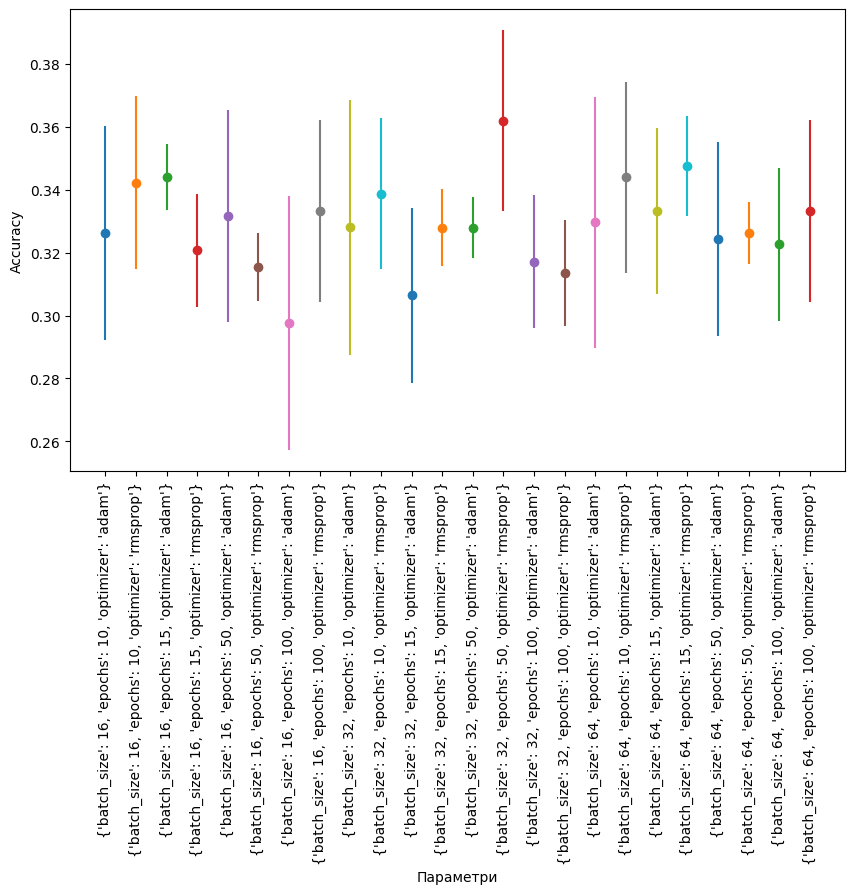

In [69]:
import matplotlib.pyplot as plt

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

param_strings = [str(param) for param in params]

plt.figure(figsize=(10, 6))
for mean, std, param_str in zip(means, stds, param_strings):
    plt.errorbar(param_str, mean, yerr=std, fmt='o', label=param_str)

plt.xlabel('Параметри')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.show()


In [ ]:
from keras.models import Model
from keras.layers import Input, Average
from keras.models import clone_model


base_model1 = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') 
]) 
base_model2 = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') 
])  
base_model3 = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

base_model1_clone = clone_model(base_model1)
base_model2_clone = clone_model(base_model2)
base_model3_clone = clone_model(base_model3)

input_layer = Input(shape=(img_height, img_width, 3))

output1 = base_model1_clone(input_layer)
output2 = base_model2_clone(input_layer)
output3 = base_model3_clone(input_layer)


ensemble_output = Average()([output1, output2, output3])


ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = ensemble_model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
18/18 [==============================] - 119s 6s/step - loss: 1.5316 - accuracy: 0.3297 - val_loss: 1.1033 - val_accuracy: 0.3237
Epoch 2/10
18/18 [==============================] - 110s 6s/step - loss: 1.1146 - accuracy: 0.3441 - val_loss: 1.1294 - val_accuracy: 0.3741
Epoch 3/10
18/18 [==============================] - 110s 6s/step - loss: 1.1145 - accuracy: 0.2957 - val_loss: 1.1013 - val_accuracy: 0.3453
Epoch 4/10
18/18 [==============================] - 111s 6s/step - loss: 1.1001 - accuracy: 0.3297 - val_loss: 1.0996 - val_accuracy: 0.3525
Epoch 5/10
18/18 [==============================] - 110s 6s/step - loss: 1.1006 - accuracy: 0.4226 - val_loss: 1.0987 - val_accuracy: 0.4381
Epoch 6/10
18/18 [==============================] - 110s 6s/step - loss: 1.1004 - accuracy: 0.4011 - val_loss: 1.0986 - val_accuracy: 0.4165
Epoch 7/10
18/18 [==============================] - 108s 6s/step - loss: 1.1008 - accuracy: 0.4190 - val_loss: 1.0975 - val_accuracy: 0.4809
Epoch 8/10
18

In [ ]:
from scipy.stats import mode

preds_model1 = base_model1.predict(X_val)
preds_model2 = base_model2.predict(X_val)
preds_model3 = base_model3.predict(X_val)

all_preds = np.array([[np.argmax(pred) for pred in preds_model1], [np.argmax(pred) for pred in preds_model2], [np.argmax(pred) for pred in preds_model3]])
ensemble_preds, _ = mode(all_preds, axis=0)

ensemble_accuracy = np.mean([np.argmax(pred) for pred in preds_model2] == y_val)
print("Ensemble Accuracy:", ensemble_accuracy)

5/5 [==============================] - 1s 87ms/step
Ensemble Accuracy: 0.58848920863309355


In [ ]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32
)

Epoch 1/50
18/18 [==============================] - 21s 1s/step - loss: 1.0773 - accuracy: 0.4803 - val_loss: 0.9997 - val_accuracy: 0.5180
Epoch 2/50
18/18 [==============================] - 19s 1s/step - loss: 0.9690 - accuracy: 0.5197 - val_loss: 0.9050 - val_accuracy: 0.5468
Epoch 3/50
18/18 [==============================] - 19s 1s/step - loss: 0.9663 - accuracy: 0.5484 - val_loss: 0.9542 - val_accuracy: 0.5612
Epoch 4/50
18/18 [==============================] - 19s 1s/step - loss: 0.9602 - accuracy: 0.5466 - val_loss: 0.8715 - val_accuracy: 0.5755
Epoch 5/50
18/18 [==============================] - 19s 1s/step - loss: 0.9395 - accuracy: 0.5502 - val_loss: 0.9144 - val_accuracy: 0.5612
Epoch 6/50
18/18 [==============================] - 19s 1s/step - loss: 0.9023 - accuracy: 0.5878 - val_loss: 0.9289 - val_accuracy: 0.5971
Epoch 7/50
18/18 [==============================] - 18s 1s/step - loss: 0.9228 - accuracy: 0.5681 - val_loss: 0.9014 - val_accuracy: 0.5612
Epoch 8/50
18/18 [==

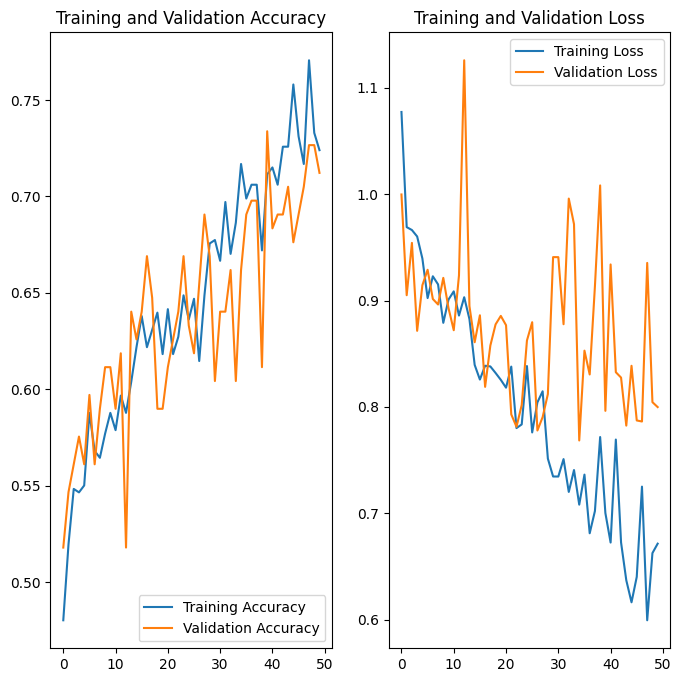

In [ ]:
graf(history)

In [ ]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=28,
    batch_size=32
)

Epoch 1/28
18/18 [==============================] - 22s 1s/step - loss: 0.6598 - accuracy: 0.7348 - val_loss: 0.8199 - val_accuracy: 0.7482
Epoch 2/28
18/18 [==============================] - 20s 1s/step - loss: 0.5467 - accuracy: 0.8100 - val_loss: 0.8487 - val_accuracy: 0.7626
Epoch 3/28
18/18 [==============================] - 20s 1s/step - loss: 0.4737 - accuracy: 0.8154 - val_loss: 0.8584 - val_accuracy: 0.7266
Epoch 4/28
18/18 [==============================] - 21s 1s/step - loss: 0.4985 - accuracy: 0.7957 - val_loss: 0.9035 - val_accuracy: 0.7410
Epoch 5/28
18/18 [==============================] - 20s 1s/step - loss: 0.5516 - accuracy: 0.7903 - val_loss: 0.8182 - val_accuracy: 0.7338
Epoch 6/28
18/18 [==============================] - 20s 1s/step - loss: 0.5159 - accuracy: 0.8136 - val_loss: 1.0239 - val_accuracy: 0.7122
Epoch 7/28
18/18 [==============================] - 20s 1s/step - loss: 0.5099 - accuracy: 0.7921 - val_loss: 1.0054 - val_accuracy: 0.7194
Epoch 8/28
18/18 [==

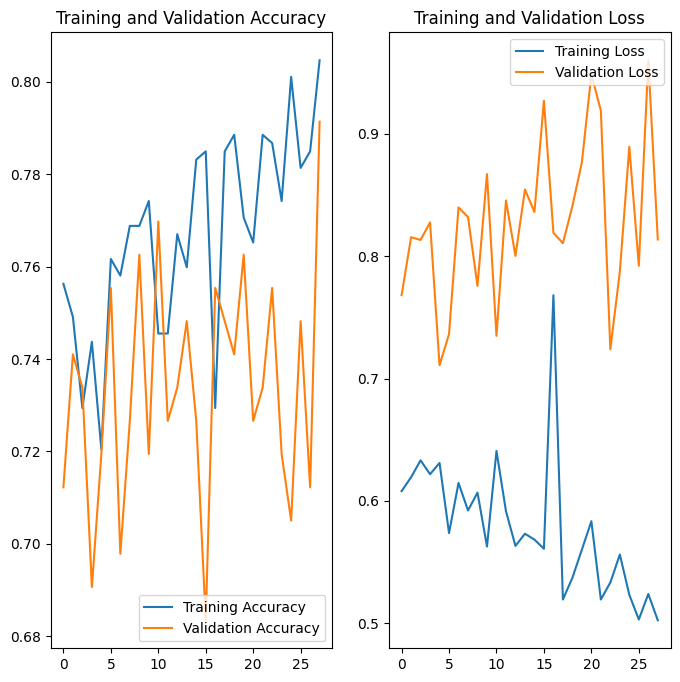

In [ ]:
graf(history)